## 1. Import libraries

In [1]:
import re
import math
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## 2. Functions

In [2]:
def columnas_por_tipo(
    df: pd.DataFrame,
    incluir_category: bool = True,
    detect_bool_numeric: bool = True,
    detect_bool_strings: bool = True,
) -> dict[str, list[str]]:
    """
    Devuelve columnas por tipo:
      - 'categorical': dtype object (y 'category' si incluir_category=True) EXCLUYENDO las que son booleanos tipo texto (Sí/No, True/False, etc.)
      - 'numeric'    : columnas numéricas (excluye bool nativo y binarios 0/1 si detect_bool_numeric=True)
      - 'boolean'    : bool nativo + binarios 0/1 + textos mapeables a booleano (si detect_* están activos)
      - 'dates'      : columnas datetime64 (cualquier tz)
    """

    # 1) bases por dtype
    inc = ["object"] + (["category"] if incluir_category else [])
    cat_cols  = df.select_dtypes(include=inc).columns.tolist()
    bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
    date_cols = [c for c in df.columns if pd.api.types.is_datetime64_any_dtype(df[c])]
    num_cols  = [c for c in df.select_dtypes(include=["number"]).columns if c not in bool_cols]

    # 2) detectar booleanos numéricos binarios (0/1) y moverlos de numeric -> boolean
    if detect_bool_numeric:
        bin_num_cols = []
        for c in num_cols:
            s = pd.to_numeric(df[c], errors="coerce")
            u = set(pd.unique(s.dropna()))
            if len(u) <= 2 and u.issubset({0, 1}):
                bin_num_cols.append(c)
        # mover
        bool_cols.extend(bin_num_cols)
        num_cols = [c for c in num_cols if c not in bin_num_cols]

    # 3) detectar booleanos en texto/categoría (Sí/No, True/False, etc.) y moverlos de categorical -> boolean
    if detect_bool_strings and cat_cols:
        true_vals  = {"true","t","si","sí","s","y","yes","1","verdadero"}
        false_vals = {"false","f","no","n","0","falso"}

        def _norm(x):
            return str(x).strip().lower()

        text_bool_cols = []
        for c in cat_cols:
            u = pd.Series(df[c].dropna().unique()).map(_norm)
            if len(u) <= 2 and set(u).issubset(true_vals.union(false_vals)):
                text_bool_cols.append(c)

        # mover
        bool_cols.extend(text_bool_cols)
        cat_cols = [c for c in cat_cols if c not in text_bool_cols]

    # 4) quitar cualquier date col de otras listas por seguridad
    cat_cols = [c for c in cat_cols if c not in date_cols]
    num_cols = [c for c in num_cols if c not in date_cols]
    bool_cols = sorted(set(bool_cols))
    cat_cols  = sorted(set(cat_cols))
    num_cols  = sorted(set(num_cols))
    date_cols = sorted(set(date_cols))

    return {
        "categorical": cat_cols,
        "numeric": num_cols,
        "boolean": bool_cols,
        "dates": date_cols,
    }


def missing_pct_table(df: pd.DataFrame, gt: float = 0.0, decimals: int = 2) -> pd.DataFrame:
    """
    Devuelve una tabla con columnas cuyo % de nulos es > gt.
    - df: DataFrame de entrada (ej.: num_df).
    - gt: umbral estricto (por defecto, 0.0 → muestra > 0%).
    - decimals: decimales para redondeo del %.

    Retorna columnas: ['columna', 'n_faltantes', 'pct_faltantes'] ordenadas desc.
    """
    n = len(df)
    stats = pd.DataFrame({
        "columna": df.columns,
        "n_faltantes": df.isna().sum().values
    })
    stats["pct_faltantes"] = (stats["n_faltantes"] / n * 100).round(decimals)
    stats = stats[stats["pct_faltantes"] > gt]\
             .sort_values("pct_faltantes", ascending=False)\
             .reset_index(drop=True)
    return stats


def summarize_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    """Resumen de outliers por IQR para cada columna numérica del DF."""
    rows = []
    for c in df.columns:
        x = pd.to_numeric(df[c], errors="coerce").dropna().values
        if x.size == 0:
            continue
        q1 = np.percentile(x, 25)
        q3 = np.percentile(x, 75)
        iqr = q3 - q1
        if iqr == 0:
            lower, upper = q1, q3
        else:
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
        n_out = int(((x < lower) | (x > upper)).sum())
        n = int(x.size)
        rows.append({
            "columna": c,
            "n": n,
            "q1": q1, "q3": q3, "iqr": iqr,
            "lower_fence": lower, "upper_fence": upper,
            "n_outliers": n_out, "pct_outliers": round(100 * n_out / n, 2),
            "min": float(np.min(x)), "max": float(np.max(x)),
            "mean": float(np.mean(x)), "median": float(np.median(x)),
            "std": float(np.std(x, ddof=1)) if n > 1 else 0.0
        })
    return pd.DataFrame(rows).sort_values("pct_outliers", ascending=False).reset_index(drop=True)


def select_columns_by_outlier_pct(summary_df: pd.DataFrame, threshold: float, top: int | None = None) -> list[str]:
    """Columnas con % de outliers >= threshold (opcional: limitar a top N)."""
    sel = summary_df[summary_df["pct_outliers"] >= threshold].sort_values("pct_outliers", ascending=False)
    if top is not None:
        sel = sel.head(top)
    return sel["columna"].tolist()


def plot_hist_and_box_side_by_side(df: pd.DataFrame, columns: list[str], bins: int = 30):
    """Para cada columna: histograma + boxplot horizontal, lado a lado."""
    for c in columns:
        x = pd.to_numeric(df[c], errors="coerce").dropna().values
        if x.size == 0:
            continue
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        # Histograma
        axes[0].hist(x, bins=bins)
        axes[0].set_title(f"Histograma - {c}")
        axes[0].set_xlabel(c)
        axes[0].set_ylabel("Frecuencia")
        # Boxplot horizontal
        axes[1].boxplot(x, vert=False, showfliers=True)
        axes[1].set_title(f"Boxplot - {c}")
        axes[1].set_xlabel(c)
        plt.tight_layout()
        plt.show()


def visualize_high_outlier_numeric(num_df: pd.DataFrame, threshold: float = 5.0, top: int | None = None, bins: int = 30) -> pd.DataFrame:
    """
    Pipeline: resume outliers, filtra por umbral y grafica hist+box para esas columnas.
    Retorna el subset del resumen para las columnas seleccionadas.
    """
    summary = summarize_outliers_iqr(num_df)
    cols = select_columns_by_outlier_pct(summary, threshold=threshold, top=top)
    plot_hist_and_box_side_by_side(num_df, cols, bins=bins)
    return summary[summary["columna"].isin(cols)][["columna", "pct_outliers", "n_outliers", "n"]]


def tratar_outliers_gt20(df: pd.DataFrame,
                         cols: list[str] | None = None,
                         q_low: float = 0.05,
                         q_high: float = 0.95,
                         caps: dict[str, tuple[float, float]] | None = None,
                         threshold: float = 20.0):
    """
    Clip (winsorize) columnas numéricas con % de outliers (IQR) > threshold.
    - Si 'caps' es None: ajusta en df (calcula umbrales p5–p95 por columna afectada).
    - Si 'caps' viene dado: SOLO aplica esos umbrales (útil para TEST).
    Devuelve: (df_tratado, caps_usados)

    caps_usados = {col: (lower_cap, upper_cap)} con valores numéricos para clip.
    NaN se preservan.
    """
    out = df.copy()
    if cols is None:
        cols = out.select_dtypes(include=np.number).columns.tolist()

    used_caps = {} if caps is None else dict(caps)

    # Fitear umbrales en df (TRAIN)
    if caps is None:
        for c in cols:
            s = pd.to_numeric(out[c], errors="coerce")
            x = s.dropna().values
            if x.size == 0:
                continue
            q1, q3 = np.percentile(x, 25), np.percentile(x, 75)
            iqr = q3 - q1
            if iqr == 0:
                pct_out = 0.0
            else:
                lower_iqr = q1 - 1.5 * iqr
                upper_iqr = q3 + 1.5 * iqr
                pct_out = 100.0 * (((x < lower_iqr) | (x > upper_iqr)).sum()) / x.size

            if pct_out > threshold:
                lo = s.quantile(q_low)
                hi = s.quantile(q_high)
                if pd.notna(lo) and pd.notna(hi) and lo < hi:
                    used_caps[c] = (float(lo), float(hi))

    # Aplicar umbrales (TRAIN o TEST)
    for c, (lo, hi) in used_caps.items():
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").clip(lo, hi)

    return out, used_caps


def zero_variance_columns(df: pd.DataFrame, numeric_only: bool = True) -> list[str]:
    """
    Retorna las columnas con varianza cero.
    Criterio: nunique(dropna=True) <= 1  (todas las no nulas son iguales).
    - numeric_only=True: evalúa solo columnas numéricas.
    """
    cols = df.select_dtypes(include=np.number).columns if numeric_only else df.columns
    return [c for c in cols if df[c].nunique(dropna=True) <= 1]


def multicollinearity_candidates(df: pd.DataFrame, thr: float = 0.90, numeric_only: bool = True, verbose: bool = True):
    """
    Detecta pares con |correlación| >= thr y sugiere qué columna eliminar en cada caso.
    Regla simple: en cada par, se elimina la columna con mayor 'correlación media' con el resto
    (más redundante). No modifica el DataFrame original.

    Retorna:
      - cols_to_drop: lista de columnas sugeridas para eliminar
      - decisions:    lista de tuplas (col1, col2, corr_abs, drop, keep)
    """
    X = df.select_dtypes(include=np.number) if numeric_only else df
    # quitar constantes (no aportan y complican corr)
    X = X.loc[:, X.nunique(dropna=True) > 1]

    if X.shape[1] <= 1:
        if verbose:
            print("No hay suficientes columnas para evaluar correlación.")
        return [], []

    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # pares sobre el umbral
    pairs = [(i, j, float(upper.loc[i, j]))
             for i in upper.index for j in upper.columns
             if pd.notna(upper.loc[i, j]) and upper.loc[i, j] >= thr]

    if not pairs:
        if verbose:
            print(f"No se encontraron pares con |r| >= {thr}.")
        return [], []

    # correlación media (sin diagonal=1.0)
    meanc = corr.replace(1.0, np.nan).mean()

    cols_to_drop, decisions = set(), []
    # procesar del par más correlacionado al menos
    for a, b, r in sorted(pairs, key=lambda t: t[2], reverse=True):
        if a in cols_to_drop or b in cols_to_drop:
            continue
        # descartar la más redundante (mayor correlación media); si empatan, descartar la de menor varianza
        if meanc[a] > meanc[b]:
            drop, keep = a, b
        elif meanc[b] > meanc[a]:
            drop, keep = b, a
        else:
            var = X.var(ddof=1)
            drop, keep = (a, b) if var[a] < var[b] else (b, a)
        cols_to_drop.add(drop)
        decisions.append((a, b, r, drop, keep))
        if verbose:
            print(f"({a}, {b}) |r|={r:.3f} -> drop column: {drop}, keep column: {keep}")

    return sorted(cols_to_drop), decisions


def select_by_target_corr(
    df: pd.DataFrame,
    target_col: str = "target",
    abs_threshold: float = 0.2,
    method: str = "pearson",
    numeric_only: bool = True,
    exclude: list[str] | None = None,
    return_table: bool = False,
):
    """
    Devuelve las columnas cuyo |correlación(feature, target)| >= abs_threshold.
    - abs_threshold ∈ [0,1] (p.ej., 0.2 ≈ 20% del máximo posible).
    - method: 'pearson' o 'spearman'.
    - numeric_only=True: solo evalúa columnas numéricas.
    - exclude: lista de columnas a ignorar.
    - return_table=True: además retorna un DataFrame con corr y |corr|.
    
    Retorna:
      - selected (list[str])  [y opcionalmente corr_df si return_table=True]
    """
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' no está en el DataFrame.")

    y = pd.to_numeric(df[target_col], errors="coerce")
    if y.nunique(dropna=True) <= 1:
        raise ValueError("El target no tiene variabilidad suficiente.")

    cols = df.select_dtypes(include=np.number).columns.tolist() if numeric_only else df.columns.tolist()
    if exclude:
        cols = [c for c in cols if c not in set(exclude)]
    cols = [c for c in cols if c != target_col]

    corrs = []
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        if s.nunique(dropna=True) <= 1:
            continue  # sin variación, correlación no informativa
        r = s.corr(y, method=method)
        corrs.append((c, r))

    corr_df = pd.DataFrame(corrs, columns=["feature", "corr"]).dropna()
    corr_df["abs_corr"] = corr_df["corr"].abs()
    corr_df = corr_df.sort_values("abs_corr", ascending=False).reset_index(drop=True)

    selected = corr_df.loc[corr_df["abs_corr"] >= abs_threshold, "feature"].tolist()
    return (selected, corr_df) if return_table else selected


def add_score_features(df: pd.DataFrame) -> pd.DataFrame:
    g = df.copy()

    # 1) Peor score actual (min entre sco_fin y sco_ser)
    if {"sco_fin", "sco_ser"}.issubset(g.columns):
        g["score_min"] = pd.concat(
            [pd.to_numeric(g["sco_fin"], errors="coerce"),
             pd.to_numeric(g["sco_ser"], errors="coerce")],
            axis=1
        ).min(axis=1, skipna=True)

        # 2) Desacuerdo entre scores
        #g["score_gap"] = (
        #    pd.to_numeric(g["sco_fin"], errors="coerce") -
        #    pd.to_numeric(g["sco_ser"], errors="coerce")
        #).abs()

    # 3) Tendencia 6m del financiero
    if {"sco_fin", "sco_fin_12m"}.issubset(g.columns):
        g["sco_fin_delta_12m"] = (
            pd.to_numeric(g["sco_fin"], errors="coerce") -
            pd.to_numeric(g["sco_fin_12m"], errors="coerce")
        )

    return g


def plot_cat_target_share_grouped(df, target="target", include_missing=True, max_levels=10, title_pad=18):
    """
    Barras lado a lado con % de target=0/1 por categoría.
    """
    # Solo categóricas puras (object/category), sin booleanas
    cats = df.select_dtypes(include=["object", "category"]).columns.tolist()
    cats = [c for c in cats if c != target]

    y = pd.to_numeric(df[target], errors="coerce")

    for col in cats:
        s = df[col]
        if include_missing:
            s = s.fillna("Missing")

        # Limitar a top categorías por frecuencia
        keep = s.value_counts().head(max_levels).index
        m = y.isin([0, 1]) & s.isin(keep)
        if m.sum() == 0:
            continue

        # % de target por categoría (filas suman 100%)
        tab = (pd.crosstab(s[m], y[m], normalize="index") * 100).reindex(keep)
        tab = tab.reindex(columns=[0, 1], fill_value=0)

        # Barras lado a lado
        idx = np.arange(len(tab))
        width = 0.4

        fig, ax = plt.subplots(figsize=(max(6, 0.6*len(tab)), 4), constrained_layout=True)
        ax.bar(idx - width/2, tab[0].values, width, label="target=0")
        ax.bar(idx + width/2, tab[1].values, width, label="target=1")

        ax.set_xticks(idx)
        ax.set_xticklabels(tab.index.astype(str), rotation=45, ha="right")
        ax.set_ylim(0, 100)
        ax.set_ylabel("Porcentaje (%)")
        ax.set_xlabel(col)
        ax.set_title(f"{col} — % de target por categoría", pad=title_pad)
        ax.legend()

        # Etiquetas (opcionales)
        for x, v in zip(idx - width/2, tab[0].values):
            if v > 3: ax.text(x, v + 1, f"{v:.0f}%", ha="center", va="bottom")
        for x, v in zip(idx + width/2, tab[1].values):
            if v > 3: ax.text(x, v + 1, f"{v:.0f}%", ha="center", va="bottom")

        plt.show()


def one_hot_clean(
    df: pd.DataFrame,
    include_missing: bool = True,
    drop_first: bool = True,
    max_levels: int | None = None,
    prefix_sep: str = "=",
) -> pd.DataFrame:
    """
    Convierte columnas categóricas (object/category) a dummies:
      - drop_first=True deja matriz full-rank (evita el 'dummy trap').
      - include_missing=True trata NaN como categoría 'Missing'.
      - max_levels: si se define, agrupa categorías poco frecuentes en 'Other'
        quedándose con las 'max_levels' más frecuentes antes del one-hot.
      - Elimina columnas constantes (todo 0/1) tras el encoding.
    """
    g = df.copy()
    cats = g.select_dtypes(include=["object", "category"]).columns.tolist()
    if not cats:
        return g

    # Agrupar categorías raras si se pidió
    if max_levels is not None:
        for c in cats:
            s = g[c]
            if include_missing:
                s = s.fillna("Missing")
            top = s.value_counts(dropna=False).nlargest(max_levels).index
            g[c] = np.where(s.isin(top), s, "Other")
    elif include_missing:
        g[cats] = g[cats].fillna("Missing")

    # One-hot (full-rank por variable si drop_first=True)
    dummies = pd.get_dummies(
        g[cats], drop_first=drop_first, dummy_na=False, prefix_sep=prefix_sep
    )
    out = pd.concat([g.drop(columns=cats), dummies], axis=1)

    # Eliminar columnas constantes (redundantes)
    const_cols = [c for c in out.columns if out[c].nunique(dropna=False) <= 1]
    if const_cols:
        out = out.drop(columns=const_cols)

    return out


def stratified_split(df: pd.DataFrame, target="target", test_size=0.2, random_state=42):
    # asegurar target binario y sin NaN
    y = pd.to_numeric(df[target], errors="coerce")
    m = y.isin([0, 1])
    df = df.loc[m].reset_index(drop=True)
    y = df[target].astype(int)

    train_df, test_df = train_test_split(
        df, test_size=test_size, stratify=y, random_state=random_state
    )
    return train_df, test_df


def impute_numeric_median(df: pd.DataFrame, exclude_cols: list[str] | None = None):
    """
    Imputa con la mediana SOLO columnas numéricas (excluye booleanas) que tengan NaN.
    Retorna: (df_imputado, medians_usadas)

    - exclude_cols: columnas a NO tocar (e.g., ["target"])
    """
    exclude = set(exclude_cols or [])
    df_out = df.copy()

    # Numéricas (sin booleanas)
    num_cols = df_out.select_dtypes(include=["number"]).columns.tolist()
    num_cols = [c for c in num_cols if not pd.api.types.is_bool_dtype(df_out[c]) and c not in exclude]

    # Solo las que tienen NaN
    cols_with_na = [c for c in num_cols if df_out[c].isna().any()]
    if not cols_with_na:
        return df_out, pd.Series(dtype=float, name="median")

    medians = df_out[cols_with_na].median()
    df_out[cols_with_na] = df_out[cols_with_na].fillna(medians)

    medians.name = "median"
    return df_out, medians


def cap_outliers_to_iqr_band(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    threshold: float = 0.20,      # 20% de outliers
    exclude_cols: list[str] | None = None,
    low_q: float = 0.25,
    high_q: float = 0.75,
):
    """
    Para columnas numéricas (no bool) cuya tasa de outliers en TRAIN (regla IQR 1.5x)
    supere 'threshold', acota sus valores a [low_q, high_q] (cuantiles de TRAIN).
    Aplica el mismo acotado a TEST usando los cuantiles aprendidos en TRAIN.

    Retorna:
      - train_cap: DataFrame train con capping aplicado
      - test_cap : DataFrame test  con capping aplicado
      - cols_capped: lista de columnas afectadas
      - info_df: DataFrame con outlier_rate y caps usados por columna
    """
    excl = set(exclude_cols or [])
    tr = train_df.copy()
    te = test_df.copy()

    # Numéricas (excluye booleanas y excluidas)
    num_cols = tr.select_dtypes(include=["number"]).columns.tolist()
    num_cols = [c for c in num_cols if not pd.api.types.is_bool_dtype(tr[c]) and c not in excl]
    if not num_cols:
        return tr, te, [], pd.DataFrame(columns=["outlier_rate_train","low_cap","high_cap"])

    # IQR en TRAIN
    q1 = tr[num_cols].quantile(0.25)
    q3 = tr[num_cols].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Tasa de outliers en TRAIN
    out_rate = ((tr[num_cols] < lower) | (tr[num_cols] > upper)).mean(skipna=True)

    # Columnas a tratar
    cols_capped = out_rate.index[out_rate > threshold].tolist()
    if not cols_capped:
        return tr, te, [], pd.DataFrame(columns=["outlier_rate_train","low_cap","high_cap"])

    # Caps [p25, p75] calculados SOLO en TRAIN
    low_cap = tr[cols_capped].quantile(low_q)
    high_cap = tr[cols_capped].quantile(high_q)

    # Aplicar clipping en TRAIN y TEST con los mismos caps
    for c in cols_capped:
        tr[c] = tr[c].clip(lower=low_cap[c], upper=high_cap[c])
        if c in te.columns:
            te[c] = te[c].clip(lower=low_cap[c], upper=high_cap[c])

    info_df = pd.DataFrame({
        "outlier_rate_train": out_rate.loc[cols_capped],
        "low_cap": low_cap,
        "high_cap": high_cap
    }).sort_values("outlier_rate_train", ascending=False)

    return tr, te, cols_capped, info_df


def tipos_existentes(df: pd.DataFrame, incluir_columnas: bool = False):
    """
    Retorna los tipos de datos existentes en el DataFrame.
    - incluir_columnas=False -> lista ordenada de dtypes (str).
    - incluir_columnas=True  -> dict {dtype_str: [columnas...]}.
    """
    dtypes_str = df.dtypes.astype(str)

    if not incluir_columnas:
        return sorted(dtypes_str.unique())

    grupos = {}
    for col, dt in dtypes_str.items():
        grupos.setdefault(dt, []).append(col)
    # ordenar por nombre de dtype
    return dict(sorted(grupos.items()))


def scale_numeric_train_test(train_df: pd.DataFrame,
                             test_df: pd.DataFrame,
                             exclude: list[str] = None,
                             method: str = "robust"):
    """
    Escala SOLO columnas numéricas (excluye booleanas) con parámetros aprendidos en train.
    method: 'standard' | 'minmax' | 'robust'
    Retorna: (train_scaled, test_scaled, cols_escaladas, scaler)
    """
    exclude = set(exclude or [])
    tr, te = train_df.copy(), test_df.copy()

    num_cols = tr.select_dtypes(include=["number"]).columns.tolist()
    num_cols = [c for c in num_cols
                if not pd.api.types.is_bool_dtype(tr[c]) and c not in exclude]
    if not num_cols:
        return tr, te, [], None

    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = RobustScaler()

    scaler.fit(tr[num_cols])          # <- SOLO train
    tr[num_cols] = scaler.transform(tr[num_cols])
    te[num_cols] = scaler.transform(te[num_cols])
    return tr, te, num_cols, scaler


def oversample_to_shares(
    train_df: pd.DataFrame,
    target: str = "target",
    minority_label: int = 1,
    minority_share: float = 0.40,
    majority_share: float = 0.60,
    random_state: int = 42,
):
    """
    Oversampling SOLO en train_df para alcanzar approximately:
      - minority_share del total en la clase `minority_label`
      - majority_share del total en la clase opuesta (complemento)
    Requiere imblearn. Devuelve (train_balanceado, sampler).

    Notas:
    - Solo duplica filas de la clase minoritaria (no toca la mayoritaria).
    - Si ya superás el share objetivo, no puede "reducir": retorna el df tal cual.
    """
    if target not in train_df.columns:
        raise KeyError(f"Columna '{target}' no encontrada en train_df.")
    # validar porcentajes
    if not (0 < minority_share < 1) or not (0 < majority_share < 1):
        raise ValueError("Los shares deben estar entre 0 y 1.")
    if abs(minority_share + majority_share - 1.0) > 1e-6:
        raise ValueError("minority_share + majority_share debe sumar 1.")

    df = train_df.copy()
    y = pd.to_numeric(df[target], errors="coerce")
    df = df.loc[y.isin([0, 1])].reset_index(drop=True)
    y = df[target].astype(int)

    # conteos actuales
    vc = y.value_counts()
    if set(vc.index) != {0, 1}:
        raise ValueError("El target debe ser binario con clases 0 y 1.")

    maj_label = 1 - minority_label
    n_min, n_maj = int(vc.get(minority_label, 0)), int(vc.get(maj_label, 0))
    if n_min == 0 or n_maj == 0:
        raise ValueError("No es posible oversampling si falta alguna clase en train.")

    # objetivo: n_min_target = (minority_share / majority_share) * n_maj
    ratio = minority_share / majority_share
    n_min_target = int(np.ceil(ratio * n_maj))
    if n_min_target <= n_min:
        # ya estás por encima del objetivo; no se puede des-muestrear aquí
        return df, None

    # usar estrategia dict para forzar exactamente el recuento de la clase minoritaria
    sampling_strategy = {minority_label: n_min_target}

    X = df.drop(columns=[target])
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_res, y_res = ros.fit_resample(X, y)

    df_res = pd.concat(
        [pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name=target)],
        axis=1
    ).reset_index(drop=True)
    return df_res, ros


def plot_rf_importances(pipe, top_n: int = 20):
    """
    Muestra un barplot horizontal con las Top-N importancias del Random Forest
    dentro de un Pipeline sklearn que tiene pasos:
      - 'pre': ColumnTransformer (con num/cat y OneHotEncoder)
      - 'clf': RandomForestClassifier

    Parámetros
    ----------
    pipe : sklearn.pipeline.Pipeline (ya entrenado)
    top_n : int
        Cantidad de features a mostrar (ordenadas por importancia).

    Retorna
    -------
    DataFrame con 'feature' e 'importance' (Top-N) por si querés guardarlo.
    """
    # 1) Extraer importancias y nombres de features ya transformados
    clf = pipe.named_steps["clf"]
    pre = pipe.named_steps["pre"]
    importances = getattr(clf, "feature_importances_", None)
    if importances is None:
        raise AttributeError("El estimador 'clf' no expone 'feature_importances_'. ¿Es RandomForest?")

    feat_names = pre.get_feature_names_out()

    fi = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(top_n))

    # 2) Limpieza estética de nombres (opcional)
    fi["feature"] = (fi["feature"]
                     .str.replace(r"^num__", "", regex=True)
                     .str.replace(r"^cat__", "", regex=True)
                     .str.replace("OneHotEncoder__", "", regex=False)
                     .str.replace("=", ": ", regex=False))

    # 3) Plot horizontal (más legible)
    fi_plot = fi.iloc[::-1]  # para que la más importante quede arriba
    plt.figure(figsize=(10, max(4, 0.45*len(fi_plot))))
    plt.barh(fi_plot["feature"], fi_plot["importance"])
    plt.xlabel("Importancia (Gini gain)")
    plt.title(f"Top {len(fi_plot)} Feature Importances — Random Forest")

    # Etiquetas numéricas al final de cada barra
    for i, v in enumerate(fi_plot["importance"]):
        plt.text(v, i, f"{v:.3f}", va="center", ha="left")

    plt.tight_layout()
    plt.show()
    return fi


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, classification_report, confusion_matrix
)

def train_eval_gbm(
    train: pd.DataFrame,
    test: pd.DataFrame,
    model: str = "lgbm",          # "lgbm" o "xgb"
    random_state: int = 42,
    beta: float = 1.0             # F-beta para elegir umbral (beta>1 prioriza recall)
):
    # ===== X / y
    X_train = train.drop(columns=["target"])
    y_train = train["target"].astype(int)
    X_test  = test.drop(columns=["target"])
    y_test  = test["target"].astype(int)

    # ===== split de validación (estratificado)
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=random_state
    )

    # ===== preprocesamiento: imputar + one-hot (árboles no necesitan escalar)
    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

    pre = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh",  OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), cat_cols),
    ], remainder="drop")

    # ===== manejar desbalance con pesos de clase
    pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())

    # ===== modelo
    if model.lower() == "xgb":
        from xgboost import XGBClassifier
        clf = XGBClassifier(
            n_estimators=700, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            n_jobs=-1, random_state=random_state, eval_metric="aucpr",
            scale_pos_weight=pos_weight, tree_method="hist", verbosity=0
        )
        model_name = "XGB"
    else:  # LGBM por defecto
        from lightgbm import LGBMClassifier
        clf = LGBMClassifier(
            n_estimators=800, learning_rate=0.05, num_leaves=31,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            random_state=random_state, scale_pos_weight=pos_weight, verbose=-1
        )
        model_name = "LGBM"

    pipe = Pipeline([("pre", pre), ("clf", clf)])

    # ===== entrenar en sub-train y elegir umbral por F-beta en validación
    pipe.fit(X_tr, y_tr)
    proba_val = pipe.predict_proba(X_val)[:, 1]

    p, r, thr = precision_recall_curve(y_val, proba_val)  # len(thr) = len(p)-1
    b2 = beta**2
    # F-beta para cada umbral (ignorar el último punto de PR que no tiene threshold)
    fbeta = (1 + b2) * (p[:-1] * r[:-1]) / (b2 * p[:-1] + r[:-1] + 1e-12)
    tau = thr[np.argmax(fbeta)]

    # ===== reentrenar en TODO train y evaluar en test
    pipe.fit(X_train, y_train)

    proba_test = pipe.predict_proba(X_test)[:, 1]
    pr_auc  = average_precision_score(y_test, proba_test)
    roc_auc = roc_auc_score(y_test, proba_test)
    prev = y_test.mean()

    print(f"[{model_name}] PR-AUC(test)={pr_auc:.4f} | baseline(prev)={prev:.4f} | lift={pr_auc/max(prev,1e-9):.2f}x")
    print(f"[{model_name}] ROC-AUC(test)={roc_auc:.4f}")
    print(f"Prevalencia train={y_train.mean():.4f} | val={y_val.mean():.4f} | test={prev:.4f}")
    print(f"Umbral elegido por F{beta:.1f} (validación): {tau:.3f}")

    # ===== clasificación y matriz de confusión (% por clase real)
    y_pred = (proba_test >= tau).astype(int)
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    cm_pct = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize="true") * 100

    fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
    im = ax.imshow(cm_pct, cmap="Blues")
    ax.set_title(f"Matriz de confusión (% por clase real) — {model_name}")
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(["0", "1"]); ax.set_yticklabels(["0", "1"])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i, j]}\n{cm_pct[i, j]:.1f}%", ha="center", va="center")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()

    return pipe, tau




## 3. Read Data

In [3]:
file_path = "data/Base_Evaluacion_oct_2024.xlsx"

clients_df = pd.read_excel(file_path, sheet_name=0)

print(clients_df.shape)
clients_df.head()

(8047, 104)


,ID,cal_nom_afip,edad,lc_monto,lc_monto_c,sco_ser,sco_ser_3m,sco_ser_6m,sco_ser_12m,sco_ser_3m_t,...,aper_cant_imp_3m,aper_cant_imp_12m,aper_cant_parc_12m,art_fpgo,sss_os_cod,bs_posee,com_ext_imp,com_ext_exp,ft_apocrifas,target
0,1,100,37.0,28078,6187,275,275,246,229,0,...,0,0,0,0,111209,0,0,0,0,0
1,2,0,22.0,24268,8437,204,198,253,142,0,...,0,0,0,0,0,0,0,0,0,1
2,3,100,44.0,169296,53144,873,892,993,959,0,...,0,0,0,0,0,1,0,0,0,0
3,4,100,32.0,47394,5468,464,438,429,554,0,...,0,0,0,0,119302,0,0,0,0,0
4,5,100,63.0,647073,134891,999,955,999,999,0,...,0,0,0,0,0,1,0,0,0,0


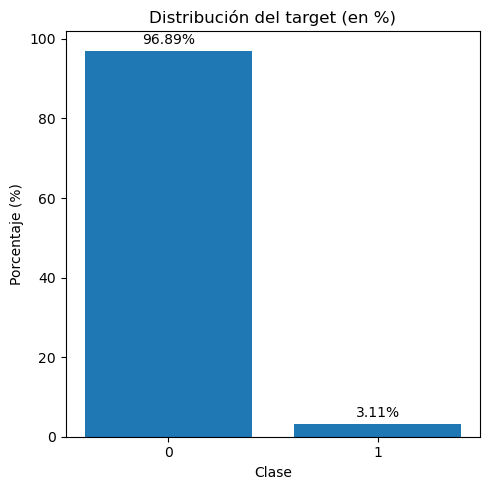

In [4]:
y = pd.to_numeric(clients_df["target"], errors="coerce")
y = y[y.isin([0, 1])]

pct = (y.value_counts(normalize=True).sort_index() * 100)

plt.figure(figsize=(5, 5))
bars = plt.bar(pct.index.astype(str), pct.values)
for i, v in enumerate(pct.values):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center", va="bottom")
plt.title("Distribución del target (en %)")
plt.xlabel("Clase"); plt.ylabel("Porcentaje (%)")
plt.ylim(0, max(100, pct.max() + 5))
plt.tight_layout()
plt.show()

**Insights**
- El dataset consiste en un registro por cliente por mes. Tenemos 8047 registros, con 103 features y un target booleano que define "Default Crediticio" (target=1), o no (target=0).
- El dataset se encuentra desbalanceado, donde la clase minoritaria es la de si tener Default Crediticio (target=1). Por lo cual trabajaremos más adelante una técnica de balanceo de clases, para aumentar la clase minoritaria.



## 4. Data dictionary

| Descripcion_Web                              | Descripcion_Batch   | Tipo       |   Longitud_Max |
|:---------------------------------------------|:--------------------|:-----------|---------------:|
| ID_Telecom (No incluir en Web)               | GT_ID               | Entero     |             11 |
| Nro_Documento (No incluir en Web)            | GT_DOC_NRO          | Documento  |             11 |
| Titular (No incluir en Web)                  | GT_TITULAR          | Texto      |            350 |
| Genero (No incluir en Web)                   | GT_GENERO           | Texto      |              1 |
| Tipo Documento                               | DOC_TIPO            | Texto      |              4 |
| Nro. Documento                               | DOC_NRO             | Documento  |             11 |
| Nombre                                       | NOMBRE              | Texto      |            180 |
| Apellido                                     | APELLIDO            | Texto      |            180 |
| Razón Social                                 | R_SOCIAL            | Texto      |            120 |
| % Calidad Nombre                             | CAL_NOM_AFIP        | Porcentaje |              3 |
| Genero                                       | GENERO              | Texto      |             13 |
| Fecha Nacimiento                             | FEC_NAC             | Fecha      |              8 |
| Edad                                         | EDAD                | Entero     |              3 |
| Tipo Persona                                 | PER_TIPO            | Texto      |             10 |
| Tipo Sociedad                                | SOC_TIPO            | Texto      |            120 |
| Tipo Cliente                                 | CLI_TIPO            | Texto      |              4 |
| Riesgo Descripción                           | SDR_DESC            | Texto      |            120 |
| Riesgo Explicación                           | SDR_EXPL            | Texto      |            120 |
| Riesgo Código                                | SDR_COD             | Texto      |              6 |
| Tipo Límite                                  | LC_TIPO             | Texto      |              1 |
| Monto Límite                                 | LC_MONTO            | Moneda     |             20 |
| Monto Límite Cuota                           | LC_MONTO_C          | Moneda     |             20 |
| Score Servicio                               | SCO_SER             | Entero     |              3 |
| Score Servicio (-3 Ms)                       | SCO_SER_3M          | Entero     |              3 |
| Score Servicio (-6 Ms)                       | SCO_SER_6M          | Entero     |              3 |
| Score Servicio (-12 Ms)                      | SCO_SER_12M         | Entero     |              3 |
| Score Servicio Tendencia (-3 Ms)             | SCO_SER_3M_T        | Entero     |             20 |
| Score Servicio Tendencia (-6 Ms)             | SCO_SER_6M_T        | Entero     |             20 |
| Score Servicio Tendencia (-12 Ms)            | SCO_SER_12M_T       | Entero     |             20 |
| Score Financiero                             | SCO_FIN             | Entero     |              3 |
| Score Financiero (-3 Ms)                     | SCO_FIN_3M          | Entero     |              3 |
| Score Financiero (-6 Ms)                     | SCO_FIN_6M          | Entero     |              3 |
| Score Financiero (-12 Ms)                    | SCO_FIN_12M         | Entero     |              3 |
| Score Financiero Tendencia (-3 Ms)           | SCO_FIN_3M_T        | Entero     |             20 |
| Score Financiero Tendencia (-6 Ms)           | SCO_FIN_6M_T        | Entero     |             20 |
| Score Financiero Tendencia (-12 Ms)          | SCO_FIN_12M_T       | Texto      |              8 |
| Telcos Consultadas - Cantidad (-3 Ms)        | TELCOS_CONS_3M      | Entero     |              6 |
| Telcos Morosas - Cantidad                    | TELCOS_MOR_CANT     | Entero     |              6 |
| Telcos Morosas - Deuda Total                 | TELCOS_MOR_DDA      | Moneda     |             20 |
| Telcos Morosas - Antigüedad Max. Deuda       | TELCOS_MOR_ANT      | Entero     |              4 |
| Telcos Morosas - Cantidad (Sin G. Telecom)   | TELCOS_MOR_CANT2    | Entero     |              6 |
| Deuda Total - Movistar                       | TELCOS_DDA_MV       | Moneda     |             20 |
| Deuda Total - Telefónica                     | TELCOS_DDA_TF       | Moneda     |             20 |
| Deuda Total - Claro                          | TELCOS_DDA_CL       | Moneda     |             20 |
| Deuda Total - Personal                       | TELCOS_DDA_TP       | Moneda     |             20 |
| Deuda Total - Telecom                        | TELCOS_DDA_TA       | Moneda     |             20 |
| NSE                                          | NSE                 | Texto      |              3 |
| NSE Percentil                                | NSE_PERC            | Entero     |              3 |
| FE                                           | FE                  | Entero     |              2 |
| FE Aperturada                                | FE_MAX              | Entero     |              2 |
| Compromisos Mensuales                        | COMPR_MENS          | Moneda     |             20 |
| Ratio Compromiso Mensual / NSE               | RAT_CM-NSE          | Entero     |              6 |
| Productos Financieros Activos (-12 Ms)       | PFINA_12M           | Entero     |              6 |
| BCRA Antigüedad (Ms)                         | BCRA_ANT            | Entero     |              6 |
| BCRA Situación                               | BCRA_SIT_VG         | Entero     |              2 |
| BCRA Peor Situación (-3 Ms)                  | BCRA_PSIT_3M        | Entero     |              2 |
| BCRA Peor Situación (-6 Ms)                  | BCRA_PSIT_6M        | Entero     |              2 |
| BCRA Peor Situación (-12 Ms)                 | BCRA_PSIT_12M       | Texto      |              8 |
| BCRA Tendencia Situación (-3 Ms)             | BCRA_PSIT_3M_T      | Entero     |              2 |
| BCRA Tendencia Situación (-6 Ms)             | BCRA_PSIT_6M_T      | Entero     |              2 |
| BCRA Tendencia Situación (-12 Ms)            | BCRA_PSIT_12M_T     | Entero     |              2 |
| Bancarizado                                  | BANCRZDO            | Booleano   |              2 |
| Bancos Cantidad                              | BCO_CANT            | Entero     |              2 |
| Bancos Endeudamiento Vigente                 | BCO_ENDEU           | Moneda     |             20 |
| Bancos Descripción 1                         | BCO_DESC1           | Texto      |            120 |
| Bancos Descripción 2                         | BCO_DESC2           | Texto      |            120 |
| Bancos Descripción 3                         | BCO_DESC3           | Texto      |            120 |
| Bancos Descripción 4                         | BCO_DESC4           | Texto      |            120 |
| Bancos Descripción 5                         | BCO_DESC5           | Texto      |            120 |
| TC Cantidad                                  | TC_CANT             | Entero     |              2 |
| TC Saldo Total                               | TC_SDOT             | Moneda     |             20 |
| TC Descripción 1                             | TC_DESC1            | Texto      |            120 |
| TC Descripción 2                             | TC_DESC2            | Texto      |            120 |
| TC Descripción 3                             | TC_DESC3            | Texto      |            120 |
| TC Descripción 4                             | TC_DESC4            | Texto      |            120 |
| TC Descripción 5                             | TC_DESC5            | Texto      |            120 |
| Cheques Sin Fondos - Cantidad (-3 Ms)        | CHE_SF_CANT_3M      | Entero     |              6 |
| Cheques Sin Fondos - Monto (-3 Ms)           | CHE_SF_MTO_3M       | Moneda     |             20 |
| Cheques Sin Fondos - Cantidad (-6 Ms)        | CHE_SF_CANT_6M      | Entero     |              6 |
| Cheques Sin Fondos - Monto (-6 Ms)           | CHE_SF_MTO_6M       | Moneda     |             20 |
| P. Prendarios - Cantidad                     | PRE_PRE_CANT        | Entero     |              6 |
| P. Prendarios - Saldo Total                  | PRE_PRE_SLDO        | Moneda     |             20 |
| P. Hipotecarios - Cantidad                   | PRE_HIP_CANT        | Entero     |              6 |
| P. Hipotecarios - Saldo Total                | PRE_HIP_SLDO        | Moneda     |             20 |
| P. Personales - Cantidad                     | PRE_PER_CANT        | Entero     |              6 |
| P. Personales - Saldo Total                  | PRE_PER_SLDO        | Moneda     |             20 |
| P. Otros - Cantidad                          | PRE_OTR_CANT        | Entero     |              6 |
| P. Otros - Saldo Total                       | PRE_OTR_SLDO        | Moneda     |             20 |
| Líneas de Descubierto vigentes - Cantidad    | DESCUB_CANT         | Entero     |              6 |
| Líneas de Descubierto vigentes - Monto Total | DSCUB_MTOT          | Moneda     |             20 |
| Quiebra vigente?                             | QUIEBRA_VG          | Booleano   |              2 |
| Pedidos de Quiebra < 90 días                 | PQUIEBRA_<90        | Entero     |              6 |
| Pedidos de Quiebra > 90 días                 | PQUIEBRA_>90        | Entero     |              6 |
| RC Vigentes - Cantidad - (-6 Ms)             | RC_VG_6M            | Entero     |              6 |
| RC Vigentes - Cantidad - (-3 Ms)             | RC_VG_3M            | Entero     |              6 |
| RC Vigentes - Cantidad                       | RC_VG               | Entero     |              6 |
| RC - Fuente CAP1                             | RC_VG_FCAP1         | Entero     |              6 |
| RC - Fuente CAP2                             | RC_VG_FCAP2         | Entero     |              6 |
| RC - Fuente CAP3                             | RC_VG_FCAP3         | Entero     |              6 |
| RF Vigentes - Cantidad - (-6 Ms)             | RF_VG_6M            | Entero     |              6 |
| RF Vigentes - Cantidad - (-3 Ms)             | RF_VG_3M            | Entero     |              6 |
| RF Vigentes - Cantidad                       | RF_VG               | Entero     |              6 |
| RF - Fuente CAP1                             | RF_VG_FCAP1         | Entero     |              6 |
| RF - Fuente CAP2                             | RF_VG_FCAP2         | Entero     |              6 |
| RF - Fuente CAP3                             | RF_VG_FCAP3         | Entero     |              6 |
| Es Empleado?                                 | ES_EMPLEADO         | Entero     |              2 |
| Es Jubilado?                                 | ES_JUBILADO         | Entero     |              2 |
| Es Pensionado?                               | ES_PENSIONADO       | Entero     |              2 |
| Es Monotributista?                           | ES_MONOTRIB         | Entero     |              2 |
| Es Autónomo?                                 | ES_AUTONOMO         | Entero     |              2 |
| Es Empleador?                                | ES_EMPLEADOR        | Entero     |              2 |
| Es Integrante Sociedad?                      | ES_INTEG_SOC        | Entero     |              2 |
| Sin Actividad?                               | ES_SIN_ACTIV        | Entero     |              2 |
| Categoría Monotributo                        | CAT_MONOTRIB        | Texto      |              3 |
| Actividad Monotributo                        | ACT_MONOTRIB        | Texto      |            120 |
| Categoría Autónomo                           | CAT_AUTONOMO        | Texto      |            180 |
| Fecha de Inscripción en AFIP                 | F_INSCRIP_AFIP      | Fecha      |              8 |
| Antigüedad en AFIP                           | ANTIG_AFIP          | Entero     |              6 |
| Antigüedad Laboral Max - Empleador Vigente   | ANTIG_LABORAL_MAX   | Entero     |              6 |
| Cantidad Empleados                           | CANT_EMPLEADOS      | Entero     |              6 |
| Empleador Vigente (Max Ant) - CUIT           | EMPLEADOR_CUIT      | Entero     |             11 |
| Empleador (Max Ant)- NyA / RS                | EMPLEADOR_NOMBRE    | Texto      |            350 |
| Sector Actividad Principal                   | ACT_PPAL_SECTOR     | Texto      |             80 |
| Código de Actividad Principal                | ACT_PPAL_COD        | Entero     |             10 |
| Descripción de Actividad Principal           | ACT_PPAL_DESC       | Texto      |            350 |
| Sector Actividad Secundaria                  | ACT_SECU_SECTOR     | Texto      |             80 |
| Código de Actividad Secundaria               | ACT_SECU_COD        | Entero     |             10 |
| Descripción de Actividad Secundaria          | ACT_SECU_DESC       | Texto      |            350 |
| CLANAE - Código Grupo                        | CLANAE_COD_G        | Entero     |             10 |
| CLANAE - Descripción Grupo                   | CLANAE_DESC_G       | Texto      |            350 |
| CLANAE - Código SubGrupo                     | CLANAE_COD_SG       | Entero     |             10 |
| CLANAE - Descripción SubGrupo                | CLANAE_DESC_SG      | Texto      |            350 |
| APE Estado (Peor Situación)                  | APE_PSIT            | Entero     |              6 |
| APE Impagos - Cantidad (-3 Ms)               | APE_CANT_IMP_3M     | Entero     |              6 |
| APE Impagos - Cantidad (-12 Ms)              | APE_CANT_IMP_12M    | Entero     |              6 |
| APE Parcial - Cantidad (-12 Ms)              | APE_CANT_PARC_12M   | Entero     |              6 |
| APE Empleadores - Cantidad (-12 Ms)          | APE_CANT_ER_12M     | Entero     |              6 |
| APER Antiguedad - Máx.  (-12 Ms)             | APER_ANT_MAX_12M    | Entero     |              6 |
| APER Estado (Peor Situación)                 | APER_PSIT           | Entero     |              6 |
| APER Impagos - Cantidad (-3 Ms)              | APER_CANT_IMP_3M    | Entero     |              6 |
| APER Impagos - Cantidad (-12 Ms)             | APER_CANT_IMP_12M   | Entero     |              6 |
| APER Parcial - Cantidad (-12 Ms)             | APER_CANT_PARC_12M  | Entero     |              6 |
| Nro. contrato                                | ART_CONT            | Entero     |              6 |
| Aseguradora                                  | ART_ASEG            | Texto      |             20 |
| Estado actual                                | ART_ESTADO          | Texto      |             50 |
| Fecha inicio                                 | ART_F_INI           | Fecha      |              8 |
| Fecha finalización                           | ART_F_FIN           | Fecha      |              8 |
| Falta de pago                                | ART_FPGO            | Booleano   |              2 |
| Código obra social                           | SSS_OS_COD          | Entero     |              6 |
| Obra social                                  | SSS_OS_DESC         | Texto      |            180 |
| Fecha alta                                   | SSS_OS_ALTA         | Fecha      |              8 |
| Condición titular                            | SSS_OS_CONDI        | Texto      |             40 |
| Parentesco con titular                       | SSSO_OS_PAREN       | Texto      |            100 |
| CN Estado                                    | CN_ESTADO           | Texto      |             20 |
| CN Fecha                                     | CN_FECHA            | Fecha      |              8 |
| Posee Beneficios Sociales                    | BS_POSEE            | Booleano   |              2 |
| Beneficio 01                                 | BENF_01             | Fecha      |              8 |
| Beneficio 02                                 | BENF_02             | Fecha      |              8 |
| Beneficio 03                                 | BENF_03             | Fecha      |              8 |
| Beneficio 04                                 | BENF_04             | Fecha      |              8 |
| Beneficio 05                                 | BENF_05             | Fecha      |              8 |
| Beneficio 06                                 | BENF_06             | Fecha      |              8 |
| Beneficio 07                                 | BENF_07             | Fecha      |              8 |
| Beneficio 08                                 | BENF_08             | Fecha      |              8 |
| Beneficio 09                                 | BENF_09             | Fecha      |              8 |
| Beneficio 10                                 | BENF_10             | Fecha      |              8 |
| Dom. Fiscal - Calle                          | DF_CALLE            | Texto      |            100 |
| Dom. Fiscal - Número                         | DF_NRO              | Texto      |              6 |
| Dom. Fiscal - Piso                           | DF_PISO             | Texto      |              5 |
| Dom. Fiscal - Dpto.                          | DF_DPTO             | Texto      |              5 |
| Dom. Fiscal - Torre                          | DF_TORRE            | Texto      |              5 |
| Dom. Fiscal - Sector                         | DF_SECTOR           | Texto      |              5 |
| Dom. Fiscal - Manzana                        | DF_MZNA             | Texto      |              5 |
| Dom. Fiscal - Casa                           | DF_CASA             | Texto      |              5 |
| Dom. Fiscal - Barrio                         | DF_BARRIO           | Texto      |            100 |
| Dom. Fiscal - Localidad                      | DF_LOCAL            | Texto      |            100 |
| Dom. Fiscal - CP                             | DF_CP               | Texto      |              8 |
| Dom. Fiscal - Provincia                      | DF_PROV             | Texto      |            100 |
| Dom. Alternativo - Calle                     | DA_CALLE            | Texto      |            100 |
| Dom. Alternativo - Número                    | DA_NRO              | Texto      |              6 |
| Dom. Alternativo - Piso                      | DA_PISO             | Texto      |              5 |
| Dom. Alternativo - Dpto.                     | DA_DPTO             | Texto      |              5 |
| Dom. Alternativo - Torre                     | DA_TORRE            | Texto      |              5 |
| Dom. Alternativo - Sector                    | DA_SECTOR           | Texto      |              5 |
| Dom. Alternativo - Manzana                   | DA_MZNA             | Texto      |              5 |
| Dom. Alternativo - Casa                      | DA_CASA             | Texto      |              5 |
| Dom. Alternativo - Barrio                    | DA_BARRIO           | Texto      |            100 |
| Dom. Alternativo - Localidad                 | DA_LOCAL            | Texto      |            100 |
| Dom. Alternativo - CP                        | DA_CP               | Texto      |              8 |
| Dom. Alternativo - Provincia                 | DA_PROV             | Texto      |            100 |
| Dom. Laboral - Calle                         | DL_CALLE            | Texto      |            100 |
| Dom. Laboral - Número                        | DL_NRO              | Texto      |              6 |
| Dom. Laboral - Piso                          | DL_PISO             | Texto      |              5 |
| Dom. Laboral - Dpto.                         | DL_DPTO             | Texto      |              5 |
| Dom. Laboral - Torre                         | DL_TORRE            | Texto      |              5 |
| Dom. Laboral - Sector                        | DL_SECTOR           | Texto      |              5 |
| Dom. Laboral - Manzana                       | DL_MZNA             | Texto      |              5 |
| Dom. Laboral - Casa                          | DL_CASA             | Texto      |              5 |
| Dom. Laboral - Barrio                        | DL_BARRIO           | Texto      |            100 |
| Dom. Laboral - Localidad                     | DL_LOCAL            | Texto      |            100 |
| Dom. Laboral - CP                            | DL_CP               | Texto      |              8 |
| Dom. Laboral - Provincia                     | DL_PROV             | Texto      |            100 |
| Tel. Principal                               | TEL_PPAL            | Texto      |             12 |
| Tel. Alternativo1                            | TEL_ALT1            | Texto      |             12 |
| Tel. Alternativo2                            | TEL_ALT2            | Texto      |             12 |
| Tel. Laboral                                 | TEL_LAB             | Texto      |             12 |
| Es Importador                                | COM_EXT_IMP         | Booleano   |              2 |
| Es Exportador                                | COM_EXT_EXP         | Booleano   |              2 |
| Posee FT Apócrifas                           | FT_APOCRIFAS        | Booleano   |              2 |
| Familiares del titular                       | RELAC_FAMILIARES    | Texto      |            350 |
| Usuario                                      | CONS_USUARIO        | Entero     |              6 |
| Canal                                        | CONS_CANAL          | Entero     |             20 |
| Fecha Consulta                               | CONS_FECHA          | Fecha      |              8 |

## 5. Univariate analysis

In [5]:
# Eliminamos la columna ID, ya que no aporta información útil al modelo
clients_df.drop(columns=['ID'], inplace=True)

### 5.1 Eliminar columnas con varianza cero

In [6]:
cols_var0_all = zero_variance_columns(clients_df, numeric_only=False)
cols_var0_all

['fe',
 'fe_max',
 'pfina_12m',
 'rc_vg_otras',
 'rf_vg_fcap3',
 'rc_vg_telcos',
 'cod_ganancias',
 'com_ext_exp']

In [7]:
clients_df_filter1 = clients_df.drop(columns=cols_var0_all, inplace=False)
clients_df_filter1.shape

(8047, 95)

In [8]:
# Identificar en diferentes dataframes las variables por tipo
tipos = columnas_por_tipo(clients_df_filter1)
tipos["categorical"]

['bcra_psit_12m_t', 'sco_fin_12m_t']

In [9]:
len(tipos["numeric"])

77

In [10]:
len(tipos["boolean"])

16

In [11]:
tipos["dates"]

[]

### 5.2 Analizamos los nulos

In [12]:
# Nulos
missing_gt0_num = missing_pct_table(clients_df_filter1, gt=0.0)
missing_gt0_num.rename(columns={'n_faltantes':'# faltantes','pct_faltantes':'% faltantes'},inplace=True)
missing_gt0_num

,columna,# faltantes,% faltantes
0,sco_fin,275,3.42
1,edad,8,0.10


**Insights**
- Se observa que existe un 3,42% de nulos en la variable `sco_fin` que representa el Score financiero.
- También existen nulos en la variable `edad`, un 0.1%.

**Nulos en "edad"**

**Veamos el promedio de edad por target**

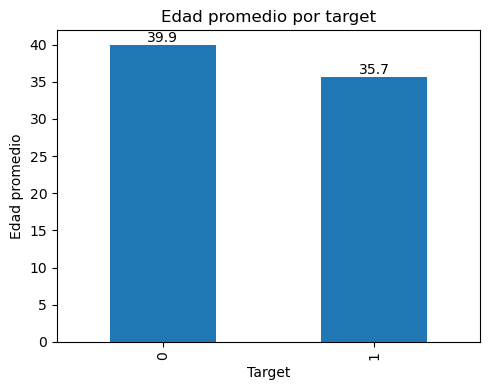

In [13]:
# Asegurar tipos numéricos
clients_df_filter1["target"] = pd.to_numeric(clients_df_filter1["target"], errors="coerce")
clients_df_filter1["edad"]   = pd.to_numeric(clients_df_filter1["edad"], errors="coerce")

# Filtrar target binario y edades válidas
d = clients_df_filter1[clients_df_filter1["target"].isin([0, 1]) & clients_df_filter1["edad"].notna()]

# Promedio de edad por target
means = d.groupby("target")["edad"].mean().sort_index()

# Barplot
plt.figure(figsize=(5, 4))
ax = means.plot(kind="bar")
for i, v in enumerate(means.values):
    ax.text(i, v, f"{v:.1f}", ha="center", va="bottom")
plt.title("Edad promedio por target")
plt.xlabel("Target")
plt.ylabel("Edad promedio")
plt.tight_layout()
plt.show()


**% de nulos por target**

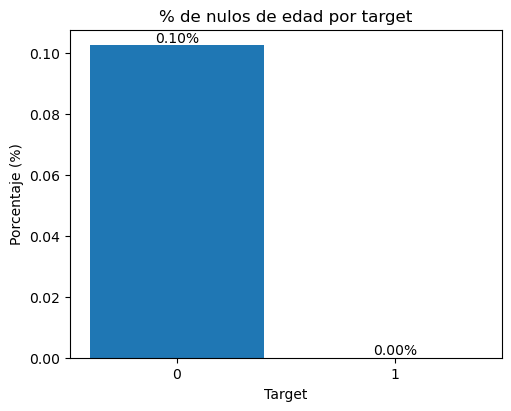

In [14]:
pct = clients_df_filter1.groupby("target")["edad"].apply(lambda s: s.isna().mean() * 100).sort_index()

#  Barplot sin tight_layout (usa constrained_layout)
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
bars = ax.bar(pct.index.astype(str), pct.values)
ax.set_title(f"% de nulos de edad por target")
ax.set_xlabel("Target"); ax.set_ylabel("Porcentaje (%)")

# etiquetas arriba de cada barra
for b, v in zip(bars, pct.values):
    ax.text(b.get_x() + b.get_width()/2, v, f"{v:.2f}%", ha="center", va="bottom")

plt.show()


**Insights**
- Se observa que quienes NO hacen default (target=0) tienen mayor edad promedio (~39.9) que quienes sí (target=1, ~35.7) —una diferencia de ~4.2 años (~10–12% menor en el grupo con default).
Pareciera que la edad se asocia inversamente con el default (más jóvenes, más riesgo), al menos en promedio.
- Aunque sea solo 0,1% y esté solo en target=1, borrarlos quita positivos y puede sesgar la evaluación, por lo que no eliminaremos esos nulos en edad, si no que los imputaremos por la mediana más adelante, tanto en train como en test.

**Nulos en Score Financiero (sco_fin)**

In [15]:
# Agregamos una variable binaria sco_fin_missing (=1 si falta el score y =0 si tiene score).
clients_df_filter1['sco_fin_missing'] = clients_df_filter1['sco_fin'].isna().astype(int)


In [16]:
# Porcentaje de scores faltantes por target
pct_score_missing = clients_df_filter1\
      .groupby("target")["sco_fin_missing"]\
      .agg(n_registros="count", n_missing_sco_fin="sum")\
      .assign(pct_missing_sco_fin=lambda d: (d["n_missing_sco_fin"] / d["n_registros"] * 100).round(2))\
      .reset_index()
pct_score_missing.rename(columns={'n_registros':'# registros','n_missing_sco_fin':'# missing sco_fin', \
                                  'pct_missing_sco_fin':'% missing sco_fin'},inplace=True)
pct_score_missing

,target,# registros,# missing sco_fin,% missing sco_fin
0,0,7797,245,3.14
1,1,250,30,12.00


In [17]:
# Promedio de score por target
clients_df_filter1\
    .groupby("target", dropna=False)["sco_fin"]\
    .mean()\
    .round(2)\
    .reset_index(name="promedio_sco_fin")\
    .sort_values("target").rename(columns={'promedio_sco_fin':'promedio sco_fin'})

,target,promedio sco_fin
0,0,470.08
1,1,343.66


**Insights**
- Como la tasa de faltantes cambia por clase (3.14% en target=0 vs 12% en target=1), la “falta” es informativa, por lo cual decidimos que imputaremos la variable score con la mediana de train (para evitar "Data leakage", que el modelo entrenado tenga acceso a datos de test). Haremos éste paso más adelante cuando definamos train y test.
- También observamos que el promedio se "sco_fin" difiere entre targets, por lo cual consideramos que es una variable importante como input del modelo.

### 5.3 Analizamos las variables numéricas, outliers y sus distribuciones.

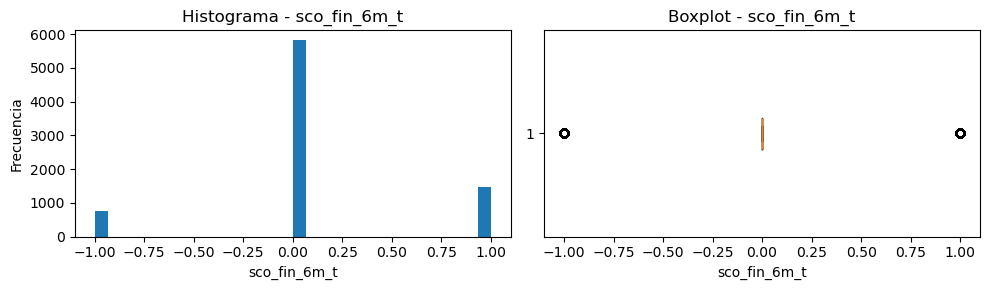

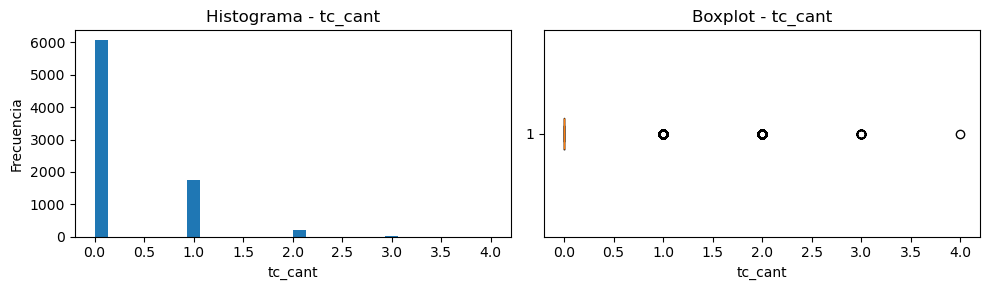

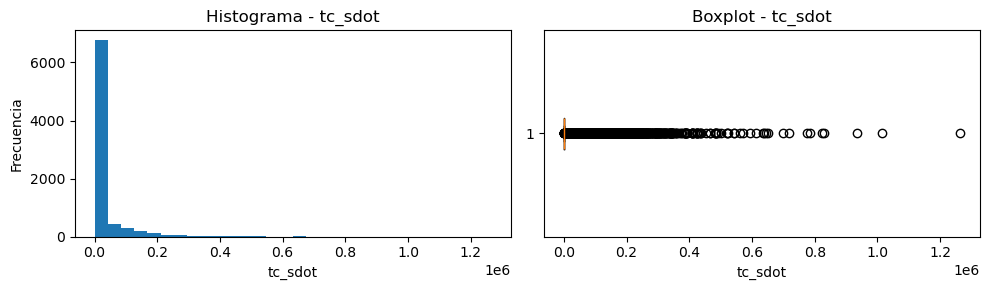

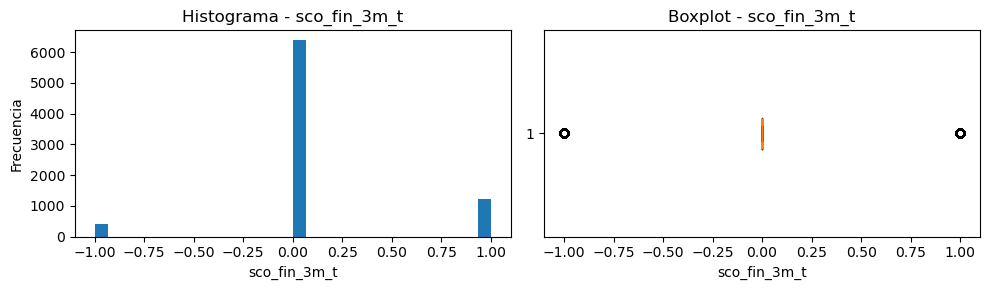

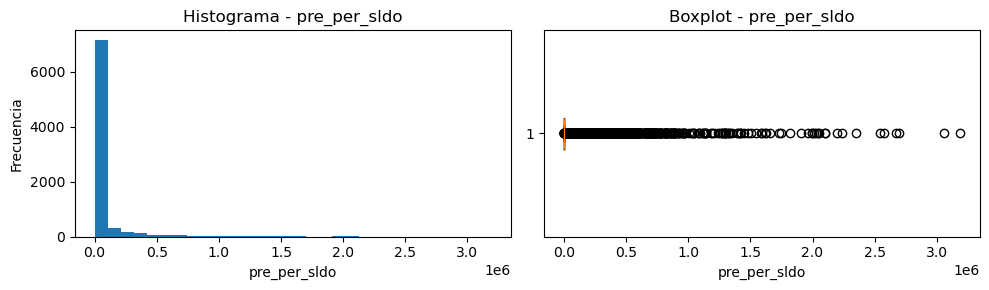

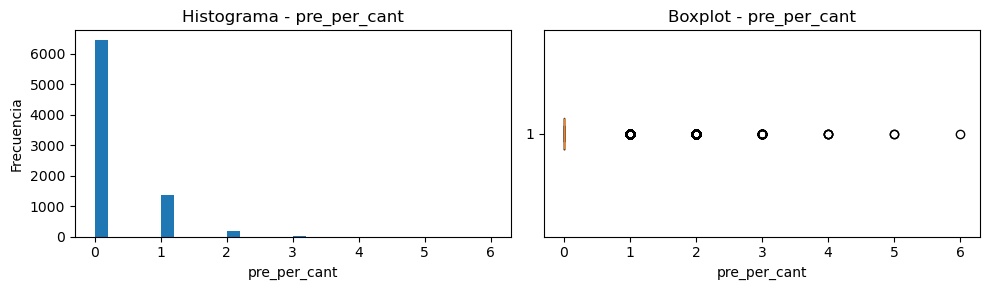

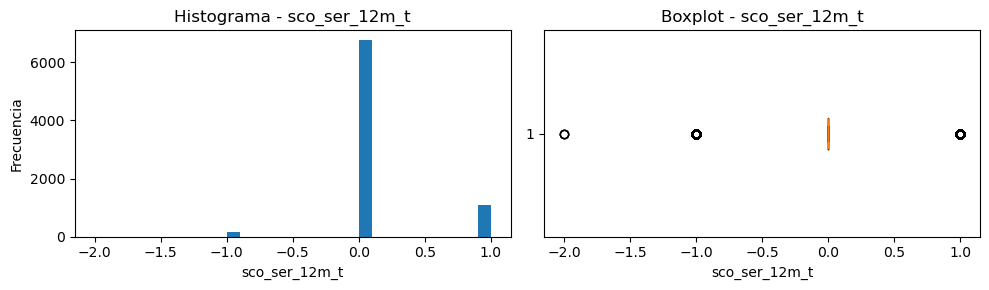

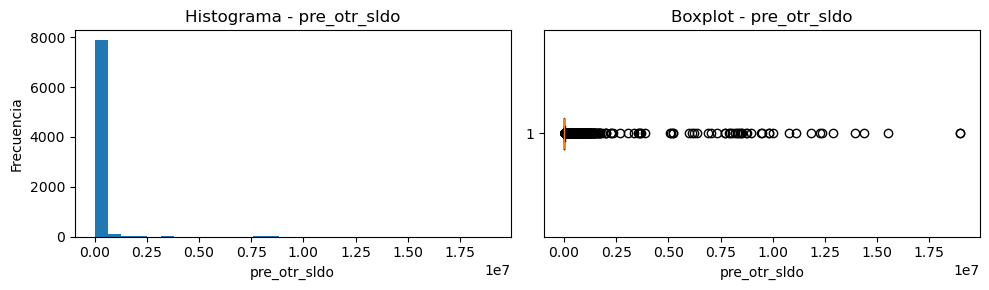

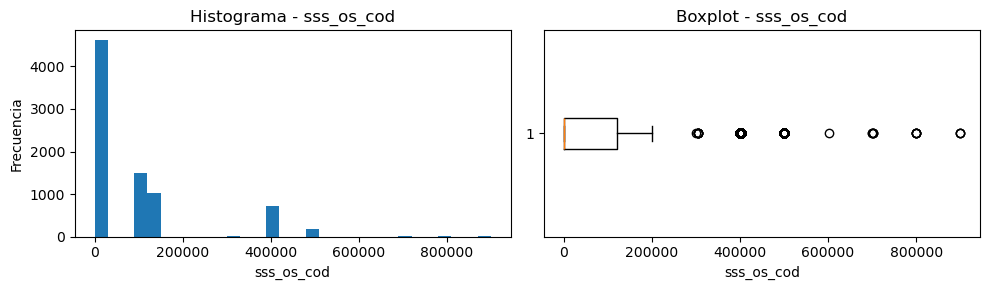

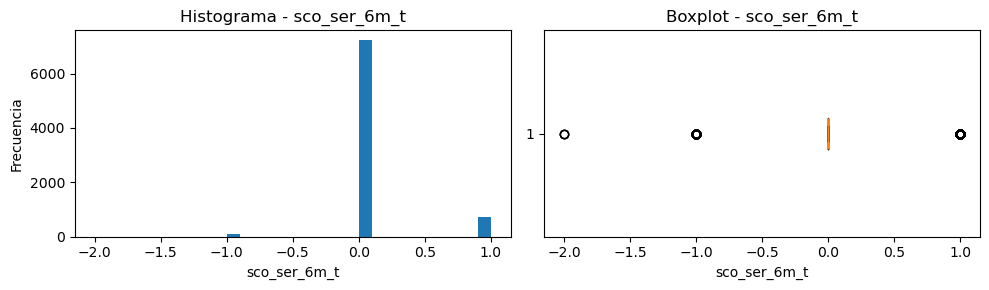

,columna,pct_outliers,n_outliers,n
0,sco_fin_6m_t,27.64,2224,8047
1,tc_cant,24.54,1975,8047
2,tc_sdot,24.54,1975,8047
3,sco_fin_3m_t,20.63,1660,8047
4,pre_per_sldo,19.96,1606,8047
5,pre_per_cant,19.96,1606,8047
6,sco_ser_12m_t,15.96,1284,8047
7,pre_otr_sldo,15.11,1216,8047
8,sss_os_cod,11.32,911,8047
9,sco_ser_6m_t,10.17,818,8047


In [18]:
# Umbral 10% y graficar las Top-20 columnas con más outliers
num_df=clients_df_filter1[tipos["numeric"]]
res_sel = visualize_high_outlier_numeric(num_df, threshold=10.0, top=20, bins=30)
res_sel

**Insights**
- Se observa diversidad de outliers, con diferentes proporciones y distribuciones, pero existen columnas con un porcentaje de outliers superior al 20%. Se decide tratar dichos outliers (IQR) limitando sus valores a los percentiles p5–p95. Este paso se aplocará tanto a train como test en un paso posterior.


## 6. Multivariate analysis

### 6.1 Delete multicollinearity variables

In [19]:
cols_to_drop, detalle = multicollinearity_candidates(clients_df_filter1, thr=0.90, numeric_only=True, verbose=True)
print("\nColumnas sugeridas para eliminar:", cols_to_drop)
# Si luego quisieras aplicarlo:
# num_df_reduced = clients_df_filter1.drop(columns=cols_to_drop)


(che_sf_mto_3m, che_sf_mto_6m) |r|=1.000 -> drop column: che_sf_mto_6m, keep column: che_sf_mto_3m
(rf_vg, rf_vg_fcap1) |r|=0.990 -> drop column: rf_vg, keep column: rf_vg_fcap1
(rc_vg_6m, rc_vg_3m) |r|=0.985 -> drop column: rc_vg_6m, keep column: rc_vg_3m
(sco_ser_3m, sco_ser_6m) |r|=0.978 -> drop column: sco_ser_3m, keep column: sco_ser_6m
(che_sf_cant_3m, che_sf_cant_6m) |r|=0.967 -> drop column: che_sf_cant_3m, keep column: che_sf_cant_6m
(sco_ser_6m, sco_ser_12m) |r|=0.961 -> drop column: sco_ser_6m, keep column: sco_ser_12m
(rc_vg, rc_vg_fcap1) |r|=0.957 -> drop column: rc_vg, keep column: rc_vg_fcap1
(sco_fin_3m, sco_fin_6m) |r|=0.945 -> drop column: sco_fin_3m, keep column: sco_fin_6m
(sco_ser, sco_ser_12m) |r|=0.925 -> drop column: sco_ser_12m, keep column: sco_ser
(sco_fin_6m, sco_fin_12m) |r|=0.915 -> drop column: sco_fin_6m, keep column: sco_fin_12m

Columnas sugeridas para eliminar: ['che_sf_cant_3m', 'che_sf_mto_6m', 'rc_vg', 'rc_vg_6m', 'rf_vg', 'sco_fin_3m', 'sco_fin_6m

In [20]:
clients_df_filter2 = clients_df_filter1.drop(columns=cols_to_drop)

### 6.2 Correlation of numerical characteristics vs. the target

In [21]:
clients_df_filter2.shape

(8047, 86)

In [22]:
# Mover 'target' al final
if "target" not in clients_df_filter2.columns:
    raise KeyError("La columna 'target' no existe en clients_df_filter2.")

cols = [c for c in clients_df_filter2.columns if c != "target"] + ["target"]
clients_df_filter2 = clients_df_filter2[cols]

In [23]:
clients_df_filter2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 86 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cal_nom_afip        8047 non-null   int64  
 1   edad                8039 non-null   float64
 2   lc_monto            8047 non-null   int64  
 3   lc_monto_c          8047 non-null   int64  
 4   sco_ser             8047 non-null   int64  
 5   sco_ser_3m_t        8047 non-null   int64  
 6   sco_ser_6m_t        8047 non-null   int64  
 7   sco_ser_12m_t       8047 non-null   int64  
 8   sco_fin             7772 non-null   float64
 9   sco_fin_12m         8047 non-null   int64  
 10  sco_fin_3m_t        8047 non-null   int64  
 11  sco_fin_6m_t        8047 non-null   int64  
 12  sco_fin_12m_t       8047 non-null   object 
 13  telcos_cons_3m      8047 non-null   int64  
 14  telcos_mor_cant     8047 non-null   int64  
 15  telcos_mor_dda      8047 non-null   int64  
 16  telcos

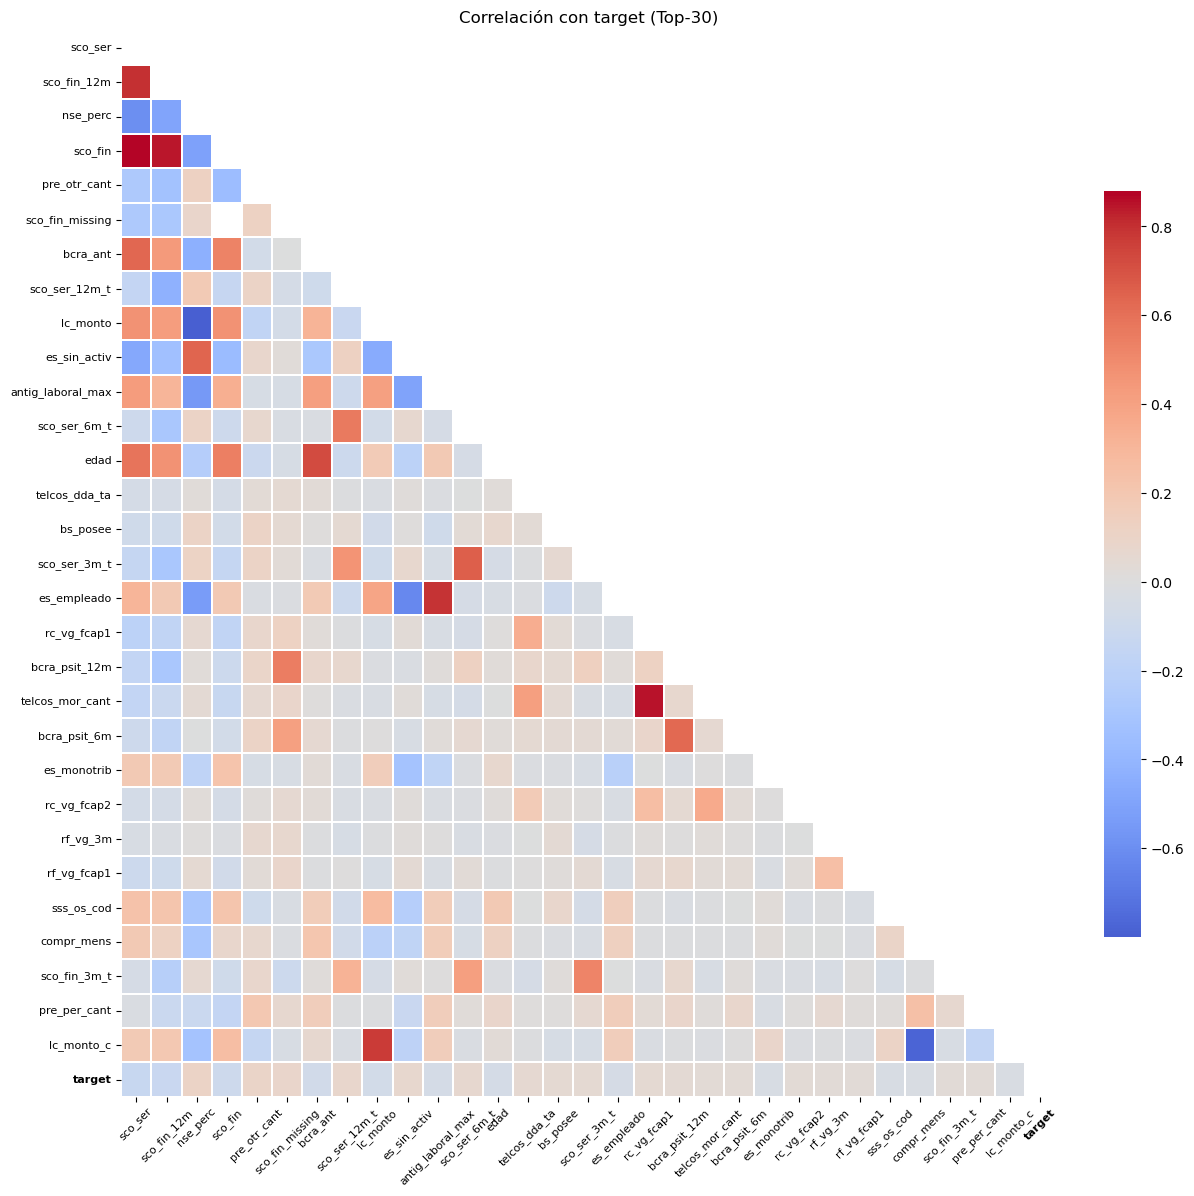

In [24]:
df = clients_df_filter2.copy()

# 1) Asegurar que 'target' exista y sea numérico
if "target" not in df.columns:
    raise KeyError("'target' no existe en el DataFrame.")
df["target"] = pd.to_numeric(df["target"], errors="coerce")

# 2) Quedarse con columnas numéricas e incluir 'target'
num = df.select_dtypes(include=["number"]).copy()
if "target" not in num.columns:
    raise TypeError(f"'target' no quedó como numérico (dtype={df['target'].dtype}).")

# 3) Correlación
corr = num.corr()

# 4) Subset legible: Top-30 por |corr con target| + 'target'
k = 30
order = (
    corr["target"].abs()
        .drop("target", errors="ignore")
        .sort_values(ascending=False)
        .head(k)
        .index.tolist()
    + ["target"]
)
corr_k = corr.loc[order, order]

# 5) Heatmap (triángulo inferior) con etiquetas legibles
mask = np.triu(np.ones_like(corr_k, dtype=bool))
fig, ax = plt.subplots(
    figsize=(min(18, 1 + 0.35*len(order)), min(18, 1 + 0.35*len(order))),
    constrained_layout=True
)
sns.heatmap(
    corr_k, mask=mask, cmap="coolwarm", center=0, linewidths=.3,
    cbar_kws={"shrink": .7}, ax=ax
)
ax.set_title("Correlación con target (Top-30)")
ax.tick_params(axis="x", rotation=45, labelsize=8)
ax.tick_params(axis="y", labelsize=8)

# Resaltar 'target' en negrita
for lab in ax.get_xticklabels():
    if lab.get_text() == "target": lab.set_fontweight("bold")
for lab in ax.get_yticklabels():
    if lab.get_text() == "target": lab.set_fontweight("bold")

plt.show()


In [25]:
# Seleccionamos las variables con un umbral de correlación con el target > 0.2
cols_fuertes, tabla = select_by_target_corr(
    clients_df_filter2, target_col="target", abs_threshold=0.2, method="pearson",
    numeric_only=True, exclude=None, return_table=True
)
print("Columnas seleccionadas:", cols_fuertes)
tabla.head(15)


Columnas seleccionadas: []


,feature,corr,abs_corr
0,sco_ser,-0.135372,0.135372
1,sco_fin_12m,-0.125736,0.125736
2,nse_perc,0.102109,0.102109
3,sco_fin,-0.102059,0.102059
4,pre_otr_cant,0.094985,0.094985
5,sco_fin_missing,0.084591,0.084591
6,bcra_ant,-0.080781,0.080781
7,sco_ser_12m_t,0.077164,0.077164
8,lc_monto,-0.075596,0.075596
9,es_sin_activ,0.069865,0.069865


In [26]:
# Correlación de Spearman
# Seleccionamos las variables con un umbral de correlación con el target > 0.2
cols_fuertes, tabla = select_by_target_corr(
    clients_df_filter2, target_col="target", abs_threshold=0.2, method="spearman",
    numeric_only=True, exclude=None, return_table=True
)
print("Columnas seleccionadas:", cols_fuertes)
tabla.head(15)

Columnas seleccionadas: []


,feature,corr,abs_corr
0,sco_ser,-0.128317,0.128317
1,sco_fin_12m,-0.125246,0.125246
2,nse_perc,0.107966,0.107966
3,sco_fin,-0.105033,0.105033
4,lc_monto,-0.100144,0.100144
5,pre_otr_cant,0.095119,0.095119
6,sco_fin_missing,0.084591,0.084591
7,bcra_ant,-0.084042,0.084042
8,pre_otr_sldo,0.081686,0.081686
9,sco_ser_12m_t,0.080486,0.080486


**Insights**
- Se observa que las variables numéricas, tienen una baja correlación absoluta con el target (< 0.2), lo cual nos dice que no hay relación lineal fuerte univariada, pero pueden aportar otro tipo de relación/información. Esto sucede tanto con la correlación de Pearson como la de Spearman (Capta relaciones monótonas -creciente/decreciente-, no sólo lineales como Pearson.)
- Por lo tanto, no hay relación lineal ni monótona fuerte a nivel univariado, esas variables, por sí solas, no muestran un patrón simple (recta o tendencia única) con el target. Igual pueden ser útiles en conjunto o realizar transformaciones.




### 6.3 Analysis of categorical variables with respect to the target

In [27]:
tipos = columnas_por_tipo(clients_df_filter2)
tipos["categorical"]

['bcra_psit_12m_t', 'sco_fin_12m_t']

Tenemos dos variables categóricas: `bcra_psit_12m_t` y `sco_fin_12m_t`, veamos su relación con respecto al target.

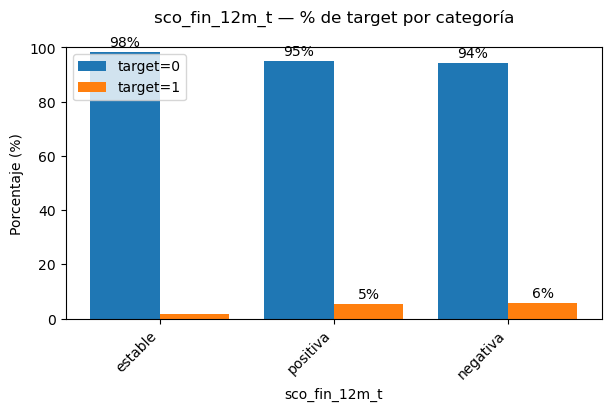

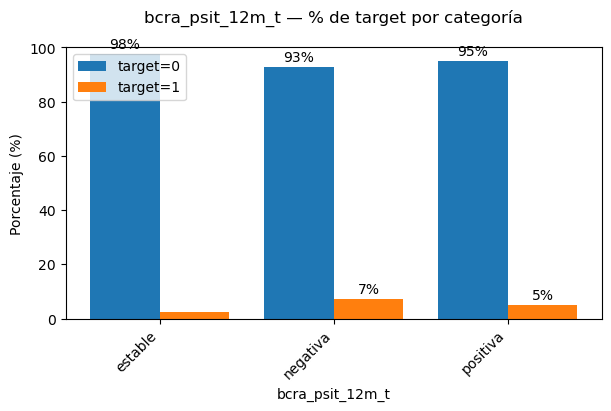

In [28]:
plot_cat_target_share_grouped(clients_df_filter2)

**Insights**
- El gráfico muestra para la variable `sco_fin_12m_t` tasas de default crediticio distintas por categoría (~2% estable vs ~5–6% positiva/negativa), por lo cual vamos a dejar ésta variable ya que aporta señal.
- Para la variable `bcra_psit_12m_t` podemos ver diferencias claras de tasa de default crediticio por categoría (p.ej., ~2% “estable”, ~5% “positiva”, ~7% “negativa”). Esa separación indica poder diferencial útil para el modelo.

**Categorical variables encoding**

Pasamos las variables categóricas a numéricas con el método One-hot encoder.

In [29]:
clients_df_filter3 = one_hot_clean(clients_df_filter2, include_missing=True, drop_first=True, max_levels=20)
clients_df_filter3.shape

(8047, 88)

## 7. Feature engineering

In [30]:
#clients_df_filter3.to_csv("clients_df_filter3.csv", index=False)

### 7.1 Train and Test creation

No conviene aumentar la clase minoritaria antes de separar en train y test. Esto es para no contaminar la evaluación (data leakage).

In [31]:
train_df, test_df = stratified_split(clients_df_filter3, target="target", test_size=0.2, random_state=42)

# Verificar proporciones
print("Train % target=1:", (train_df["target"].mean()*100).round(2))
print("Test  % target=1:", (test_df["target"].mean()*100).round(2))


Train % target=1: 3.11
Test  % target=1: 3.11


### 7.2 Train transformations and nulls imputation

In [32]:
missing_gt0_num = missing_pct_table(train_df, gt=0.0)
missing_gt0_num.rename(columns={'n_faltantes':'# faltantes','pct_faltantes':'% faltantes'},inplace=True)
missing_gt0_num

,columna,# faltantes,% faltantes
0,sco_fin,222,3.45
1,edad,8,0.12


**Imputamos los nulos en las variables `sco_fin` y `edad` con sus correspondientes medianas.**

In [33]:
# En TRAIN
train_imp, med_train = impute_numeric_median(train_df, exclude_cols=["target"])

# En TEST (reutilizando las medianas de train, sin recalcular)
test_imp = test_df.copy()
cols = med_train.index.tolist()
test_imp[cols] = test_imp[cols].fillna(med_train)

In [34]:
missing_gt0_num = missing_pct_table(train_imp, gt=0.0)
missing_gt0_num.rename(columns={'n_faltantes':'# faltantes','pct_faltantes':'% faltantes'},inplace=True)
missing_gt0_num

,columna,# faltantes,% faltantes


In [35]:
missing_gt0_num = missing_pct_table(test_imp, gt=0.0)
missing_gt0_num.rename(columns={'n_faltantes':'# faltantes','pct_faltantes':'% faltantes'},inplace=True)
missing_gt0_num

,columna,# faltantes,% faltantes


**Treatment of outliers**

Para las variables numéricas cuya cantidad de outliers supere el umbral del 20%, se acotan sus valores dentro de los percentiles p5–p95.

In [36]:
train_cap, caps = tratar_outliers_gt20(train_imp)       # fit + apply
test_cap,  _    = tratar_outliers_gt20(test_imp, caps=caps)  # apply con los mismos umbrales

### 7.3 New variables

En base a lo analizado, se decide hacer feature engineer y ver la posibilidad de transformar las variables existentes, para generar nuevas que puedan sumar información para la determinación de Default Crediticio.

Se agregan variables que se derivan de los scores existentes:

- `Peor score actual (score_min)`: si cualquiera de los dos scores es bajo, aumenta la probabilidad de default.
Cálculo: score_min = min(sco_fin, sco_ser) (por fila).

- `Tendencia 12m del financiero (sco_fin_delta_12m)`: deterioro reciente (delta negativo) es una alerta temprana de morosidad.
Cálculo: sco_fin_delta_6m = sco_fin - sco_fin_12m.
En riesgo crediticio, los datos más cercanos en el tiempo suelen predecir mejor que los muy viejos.


In [37]:
train = add_score_features(train_cap)
# Mover 'target' al final
if "target" not in train.columns:
    raise KeyError("La columna 'target' no existe.")

cols = [c for c in train.columns if c != "target"] + ["target"]
train = train[cols]
# Eliminar columnas redundantes
# sco_fin_12m
train = train.drop(columns=['sco_fin_12m'], inplace=False)
print(train.shape)

(6437, 89)


In [38]:
# Tipos presentes en train
tipos = tipos_existentes(train)
print(tipos)

['bool', 'float64', 'int64']


In [39]:
test = add_score_features(test_cap)
# Mover 'target' al final
if "target" not in test.columns:
    raise KeyError("La columna 'target' no existe.")

cols = [c for c in test.columns if c != "target"] + ["target"]
test = test[cols]
# Eliminar columnas redundantes
# sco_fin_12m
test = test.drop(columns=['sco_fin_12m'], inplace=False)
print(test.shape)

(1610, 89)


In [40]:
# Tipos presentes en test
tipos = tipos_existentes(test)
print(tipos)

['bool', 'float64', 'int64']


Ya tenemos todas las variables en formato numérico.

### 7.4 Scale numerical variables

Sólo es necesario para modelos lineales / SVM, no los usaremos en éste proyecto.

In [41]:
# Sólo es necesario para modelos lineales / SVM, no los usaremos en éste proyecto.
#train_sc, test_sc, cols, sc = scale_numeric_train_test(train_df, test_df,
#                                                       exclude=["target"], method="robust")

# Para árboles/GBM:
# No escalar (saltar esta etapa).


En modelos de árboles o GBM, escalar no mejora el desempeño ni cambia las decisiones; es como cambiar de “pesos” a “miles de pesos”: la regla de negocio sigue siendo la misma.

### 8. Baseline model (Handling class imbalance in train)

Debido a que la clase "Target=1" (si hay Default crediticio), es minoriaria. Trabajaremos en balancear las clases sólo en train.

In [42]:
# Oversampling 40% (minoría) / 60% (mayoría):
#train_bal, sampler = oversample_to_shares(
#    train, target="target", minority_label=1,
#    minority_share=0.40, majority_share=0.60, random_state=42
#)

#print("Antes:", train["target"].value_counts(normalize=True).round(2).to_dict())
#print("Después:", train_bal["target"].value_counts(normalize=True).round(2).to_dict())


In [43]:
#train = train_bal.copy()

### 8.1 Model metric

Utilizaremos como métrica: **PR-AUC (Average Precision)** que nos dice qué tan bien encontramos morosos sin llenarnos de “falsas alarmas”.

- Recall (sensibilidad) = cuántos morosos reales (positivos) identificamos.

- Precision = de los que marcamos como morosos, qué porcentaje realmente lo son (evita falsos positivos = rechazar buenos).

PR-AUC resume la precisión promedio que el modelo mantiene mientras aumentamos el recall. Con el siguiente objetivo: ¿podemos capturar más morosos sin disparar el número de buenos rechazados?

En default suele haber pocos positivos. La métrica **ROC-AUC** se centra justo donde duele el negocio: morosos detectados (recall) vs buenos mal rechazados (falsos positivos implica baja precisión). Así, mantenemos buena precisión a medida que capturamos más morosos, reduciendo incobrables sin rechazar de más.

En resumen:

- Falso positivo (FP): rechazaste un cliente bueno → pérdida de ingreso/venta.

- Falso negativo (FN): aprobaste un cliente moroso → pérdida por incobrable.

PR-AUC favorece modelos que suben el recall (menos FNs) sin hundir la precisión (controlando FPs). Es el balance rentable.

### 8.2 Random Forest baseline model

PR-AUC (test): 0.0605  | baseline (prev): 0.0311  | lift: 1.95x
ROC-AUC (test): 0.6697

Classification report (umbral=0.5):
              precision    recall  f1-score   support

           0      0.969     0.999     0.984      1560
           1      0.000     0.000     0.000        50

    accuracy                          0.968      1610
   macro avg      0.484     0.500     0.492      1610
weighted avg      0.939     0.968     0.953      1610



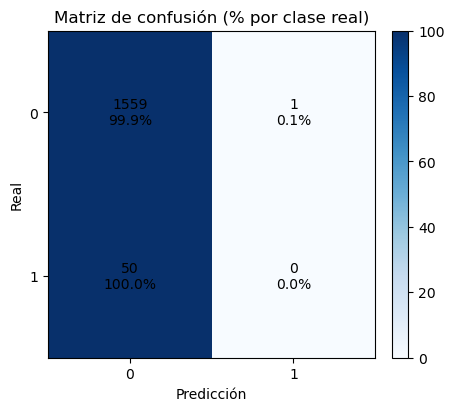

In [44]:
# =========================
# 1) Separar X / y
# =========================
def split_xy(df, target="target", drop_cols=None):
    drop_cols = (drop_cols or []) + [target]
    y = pd.to_numeric(df[target], errors="coerce").astype(int)
    X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    return X, y

X_train, y_train = split_xy(train, target="target", drop_cols=["ID"])  # quita "ID" si existe
X_test,  y_test  = split_xy(test,  target="target", drop_cols=["ID"])

# =========================
# 2) Columnas por tipo
# =========================
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
# (Si querés tratar bool como categóricas, muévelas de num_cols a cat_cols)

# =========================
# 3) Preprocesamiento
# =========================
pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh",  OneHotEncoder(handle_unknown="ignore", drop="first"))
    ]), cat_cols),
], remainder="drop")

# =========================
# 4) Modelo baseline RF
# =========================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"  # ayuda con el desbalance
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

# =========================
# 5) Entrenamiento
# =========================
pipe.fit(X_train, y_train)

# =========================
# 6) Evaluación en TEST
# =========================
proba_test = pipe.predict_proba(X_test)[:, 1]
pr_auc  = average_precision_score(y_test, proba_test)   # métrica principal
roc_auc = roc_auc_score(y_test, proba_test)             # complementaria

prevalencia = y_test.mean()  # baseline de PR-AUC
lift = (pr_auc / prevalencia) if prevalencia > 0 else np.nan

print(f"PR-AUC (test): {pr_auc:.4f}  | baseline (prev): {prevalencia:.4f}  | lift: {lift:.2f}x")
print(f"ROC-AUC (test): {roc_auc:.4f}")

# === Classification report ===
y_pred = (proba_test >= 0.5).astype(int)

print("\nClassification report (umbral=0.5):")
print(classification_report(y_test, y_pred, digits=3))

# === Matriz de confusión: conteos + porcentajes por fila ===
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])                       # conteos
cm_pct = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize="true") # % por clase real
cm_pct = cm_pct * 100

fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
im = ax.imshow(cm_pct, cmap="Blues")

ax.set_title("Matriz de confusión (% por clase real)")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"]); ax.set_yticklabels(["0", "1"])

# Anotar conteos y porcentajes en cada celda
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{cm[i, j]}\n{cm_pct[i, j]:.1f}%", ha="center", va="center")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()




**Insights**
- **PR-AUC**: Resume la precisión (qué % de los marcados son morosos, controla FP) a distintos niveles de recall (qué % de morosos capturás, controla FN). 6.05% implica que con el modelo duplicamos (**lift**=1.95) la precisión al buscar morosos con respecto al azar(baseline: 3.1%)
- El modelo aporta (≈2x sobre el azar en precisión-recall) pero, con una ROC-AUC ~0.67 , su capacidad discriminante es moderada. **ROC-AUC**: probabilidad de que un moroso quede con score mayor que un no moroso.
- Sirve para priorizar y filtrar (p.ej., a quién revisar primero), no para automatizar decisiones duras sin controles adicionales.
- Umbral=0.5 ⇒ el modelo es hiperconservador: no marca ningún default (clase 1 con precision/recall/F1 = 0).
- Accuracy 0.968 es engañosa (la clase 1 es ~3%). Con solo predecir “todo 0” ya se logra algo parecido.
- Clase 0 sale muy bien (recall 0.999), pero a costa de perder todos los morosos (recall 0.0 en clase 1). **Para negocio, inaceptable.**

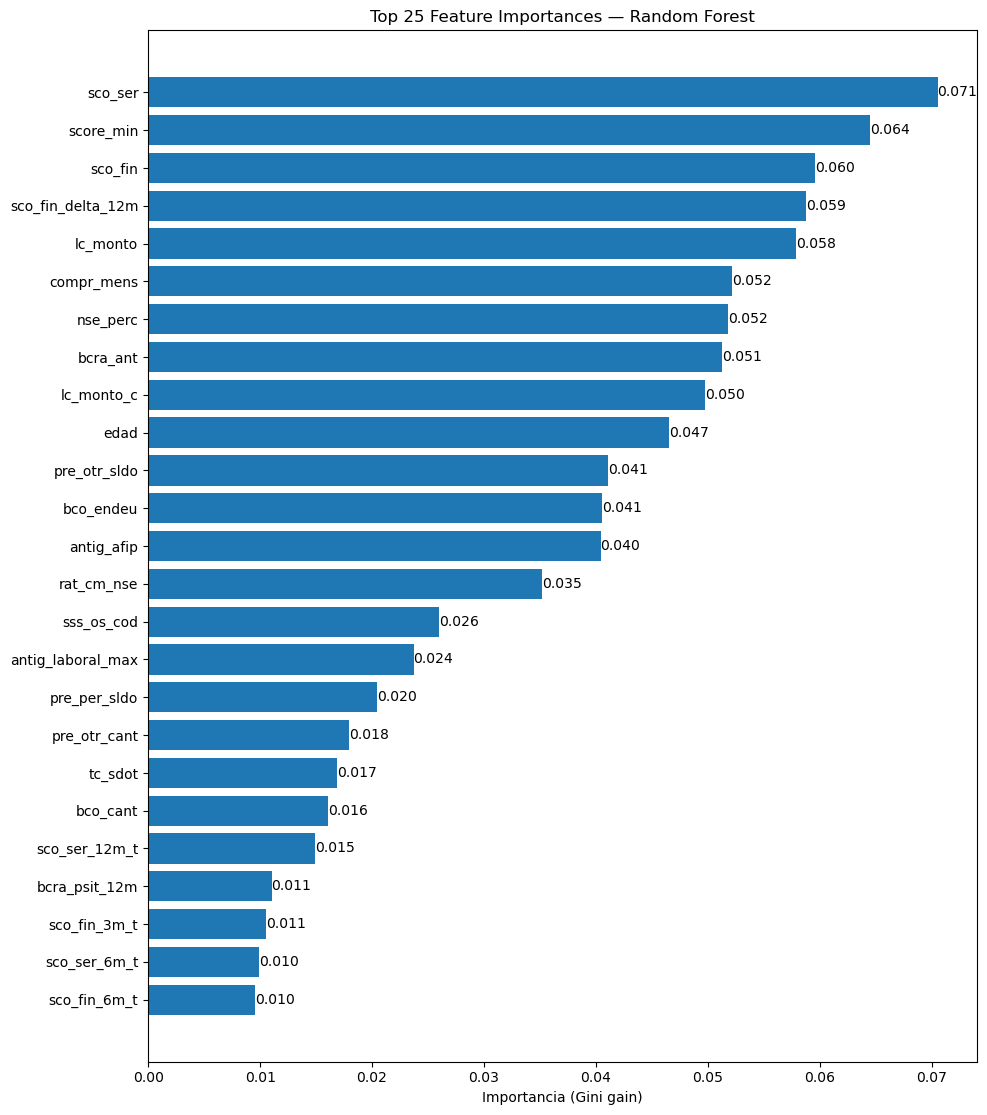

,feature,importance
4,sco_ser,0.070529
82,score_min,0.064479
8,sco_fin,0.059597
83,sco_fin_delta_12m,0.058767
2,lc_monto,0.057896
22,compr_mens,0.052144
21,nse_perc,0.051841
24,bcra_ant,0.051280
3,lc_monto_c,0.049759
1,edad,0.046557


In [45]:
top_df = plot_rf_importances(pipe, top_n=25)
top_df

### 8.3 LGBM model

Exception in thread Thread-38 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Usuario.Sooft\anaconda3\envs\telecom\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\Usuario.Sooft\anaconda3\envs\telecom\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\Usuario.Sooft\anaconda3\envs\telecom\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Usuario.Sooft\anaconda3\envs\telecom\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa2 in position 114: invalid start byte
c:\Users\Usuario.Sooft\anaconda3\envs\telecom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn

[LGBM] PR-AUC(test)=0.0551 | baseline(prev)=0.0311 | lift=1.77x
[LGBM] ROC-AUC(test)=0.6222
Prevalencia train=0.0311 | val=0.0311 | test=0.0311
Umbral elegido por F1.5 (validación): 0.019

Classification report (test):
              precision    recall  f1-score   support

           0      0.971     0.916     0.943      1560
           1      0.058     0.160     0.085        50

    accuracy                          0.893      1610
   macro avg      0.515     0.538     0.514      1610
weighted avg      0.943     0.893     0.916      1610



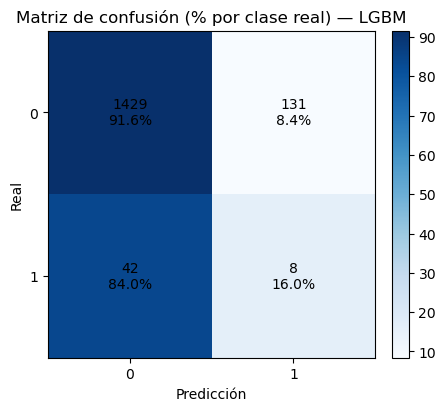

In [46]:
# LightGBM priorizando algo más el recall (beta=1.5)
lgbm_pipe, lgbm_tau = train_eval_gbm(train, test, model="lgbm", beta=1.5)

- PR-AUC = 0.0551 vs baseline (prevalencia) = 0.0311 → lift ≈ 1.77×*, la ganancia aún es modesta.
- ROC-AUC = 0.622, separación moderada (hay señal, pero lejos de un modelo fuerte).
- Recall de morosos = 16% ⇒ de 50 morosos reales, el modelo detecta ~8.
- Precisión = 5.8% ⇒ de cada 100 casos marcados, ~6 son morosos y ~94 son falsos positivos.
- El modelo sirve para priorizar (mejor que azar), no para automatizar rechazos: captura poco y genera muchos falsos positivos con este corte.
- Puede usarse como filtro inicial / ranking combinado con reglas de negocio o revisión manual.

### 8.4 XGBoost model

[XGB] PR-AUC(test)=0.0505 | baseline(prev)=0.0311 | lift=1.62x
[XGB] ROC-AUC(test)=0.6313
Prevalencia train=0.0311 | val=0.0311 | test=0.0311
Umbral elegido por F1.0 (validación): 0.079

Classification report (test):
              precision    recall  f1-score   support

           0      0.972     0.894     0.931      1560
           1      0.057     0.200     0.088        50

    accuracy                          0.872      1610
   macro avg      0.514     0.547     0.510      1610
weighted avg      0.944     0.872     0.905      1610



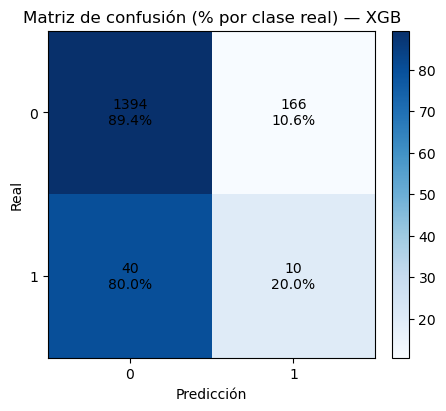

In [47]:
# XGBoost con F1 (beta=1.0)
xgb_pipe, xgb_tau = train_eval_gbm(train, test, model="xgb", beta=1.0)


- PR-AUC = 0.0505 vs baseline = 0.0311 → lift ≈ 1.62×: hay señal, pero modesta.
- ROC-AUC = 0.631: separación moderada (mejor que azar, lejos de un modelo fuerte).
- Recall de morosos = 20% → de 50 morosos reales, detecta ~10.
- Precisión = 5.7% → de cada 100 marcados, ~6 son morosos y ~94 son falsos positivos.
- Accuracy 0.872 no es buen criterio aquí (la clase 1 es ~3.1%): puede ser alta aunque el modelo falle en morosos.
- El modelo sirve para priorizar (mejor que azar), no para decisiones automáticas: captura pocos morosos y genera muchos falsos positivos con este umbral.

### Conclusión

En conclusión: Los modelos sirven como ranking/priorización, no para decisiones automáticas.
Random Forest tiene la mejor PR-AUC, pero con umbral estándar no captura; GBMs capturan algo más con umbrales bajos pero con precisión muy baja.

### Posibles mejoras

-  Continuar con el análisis de features para sumar variables, revisar variables con poco aporte y redundancias.
Prueba de otros modelos como CatBoost o incluso aplicar ajuste por hiperparámetros, para intentar obtener mejoras.
- Análisis de feature importances para tratar de reducir la cantidad de variables que están tomando los modelos.
- Comparar las métricas de train y de test para verificar que no haya overfitting (altas en train, pero más bajas en test).
- Probar si los modelos mejoran usando técnicas de reducción de dimensionalidad, como PCA. Para reducir la cantidad de variables que toma el modelo.
- Análisis de interpretabilidad de modelos con librerías como SHAP, ésto nos permite analizar las predicciones individuales. Por ejemplo responde a la pregunta: “¿Para este cliente en particular, qué variables hicieron que lo clasifiquemos como default si /default no?” o para explicar por ej: por qué un cliente fue mal clasificado.
